#### An interpretative machine learning model for classifying genetic variations using text mining of clinical literature for applications in precision medicine

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

In [241]:
# Loading all required packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import sklearn
import re
import time
import warnings

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import normalized_mutual_info_score

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

#from collections import Counter
from collections import Counter, defaultdict
from scipy.sparse import hstack



Lets first understand the data set provided and using that dataset we will try to understand the above problem in Machine Learning world. Since, the dataset is huge lets load it using python itself

In [242]:
# Loading training_variants. Its a comma seperated file
path = "/Users/marcodicio/Desktop/AML/"
data_variants = pd.read_csv(path+'training_variants')
# Loading training_text dataset. This is seperated by ||
data_text =pd.read_csv(path+"training_text",sep="\|\|",names=["ID","TEXT"],skiprows=1)

<ipython-input-242-8577068dcadf>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text =pd.read_csv(path+"training_text",sep="\|\|",names=["ID","TEXT"],skiprows=1)


In [243]:
data_variants.head(15)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [244]:
data_variants.ID.unique()

array([   0,    1,    2, ..., 3318, 3319, 3320])

<p>
    Let's understand above data. There are 4 fields above: <br>
    <ul>
        <li><b>ID : </b>Row index used to link the mutation to the clinical evidence.</li>
        <li><b>Gene : </b>The gene where this genetic mutation is located. </li>
        <li><b>Variation : </b>The change in the aminoacid for this mutation. </li>
        <li><b>Class :</b> class value 1-9, Class by which the mutation has been classified.</li>
    </ul>


In [245]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [246]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [247]:
# Checking dimention of data
data_variants.shape

(3321, 4)

In [248]:
# Checking column names in above data set
data_variants.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

### Now lets explore about data_text

In [249]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [250]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [251]:
data_text.ID.unique

<bound method Series.unique of 0          0
1          1
2          2
3          3
4          4
        ... 
3316    3316
3317    3317
3318    3318
3319    3319
3320    3320
Name: ID, Length: 3321, dtype: int64>

So above dataset have 2 columns **ID** and **Text** column. We can also observe column ID which is common in both the dataset. Lets keep exploring it.

In [252]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [253]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [254]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [255]:
data_text["TEXT"][1][:50]

' Abstract Background  Non-small cell lung cancer ('

In [256]:
# checking the dimentions
data_text.shape

(3321, 2)

So, in short my datasets looks like this
 * data_variants (ID, Gene, Variations, Class)
 * data_text(ID, text)
 
 Ok, now we understood the dataset. Lets try to understand the same problem from Machine Learning point of view

We want to predict about class of cancer(genetic variation). Now question is what kind of data is present in class column.

In [257]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The data here is of the discrete type so we have a ***classification*** problem. Since there are multiple descrete outputs possible so we are in the field of  ***Multi class*** classification problems.

***Important note*** : This is medical related problem so correct results are very important. Error can be really costly here so we would like to have result  for each class in terms of Probablity. We might not be much bothered about time taken by ML algorithm as far as it is reasonable. 

We also want our model to be highly interpritable because a medical practitioner would want to also give proper reasonining on why ML algorithm is predicting any class. 

We will evaluate our model using Confusion matrix and **Multi class log-loss**

### TEXT Preprocessing

In [258]:
# We would like to remove all stop words like a, is, an, the, ... 
stop_words = set(stopwords.words('english'))

In [259]:
def data_text_preprocess(tot_txt, ind, col):
    # Remove int values from text data as that might not be imp
    if type(tot_txt) is not int:
        string = ""
        # replacing all special char with space
        tot_txt = re.sub('[^a-zA-Z0-9\n]', ' ', str(tot_txt))
        
        # replacing extra spaces with single space
        tot_txt = re.sub('\s+',' ', str(tot_txt))
        
        # bring whole text to same lower-case scale.
        tot_txt = tot_txt.lower()
        
        for word in tot_txt.split():
        # if the word is a not a stop word then retain that word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[col][ind] = string

In [260]:
# Below code will take some time because its huge text
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

<ipython-input-259-ee94a6d5b953>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text[col][ind] = string


Let's merge both the dataset. Remember that **ID** was common column. So lets use it to merge.

In [261]:
#merging both gene_variations and text data based on ID
result = pd.merge(data_variants, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


It's very important to look for missing values. Else they create problem in final analysis

In [262]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


We can see many rows with missing data. Now the question is what to do with this missing value. One way could be that we can drop these rows having missing values or we can do some imputation in it, merging Gene and Variation column.

In [263]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +' '+result['Variation']

Let's cross check it once again if there is any missing values

In [264]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


As seen  above all missing values are gone now.

### Creating Training, Test and Validation data
Before we split the data into training, test and validation data set. We want to ensure that all spaces in Gene and Variation column to be replaced by _.

In [266]:
y_gtr = result['Class'].values
result.Gene = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

Ok, so we can now start our split process in train, test and validation data set.

In [267]:
# Splitting the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, 
                                                     y_gtr, 
                                                     stratify=y_gtr, 
                                                     test_size=0.2)

# split the train data now into train ,test and cross validation set
train_df, cv_df, y_train, y_cv = train_test_split(X_train, 
                                                  y_train, 
                                                  stratify=y_train, 
                                                  test_size=0.2)

In [268]:
print('Number of observations in train dataset:', train_df.shape[0])
print('Number of observations in test dataset:', test_df.shape[0])
print('Number of observations in cross validation dataset:', cv_df.shape[0])

Number of observations in train dataset: 2124
Number of observations in test dataset: 665
Number of observations in cross validation dataset: 532


Let's look at the distribution of data in train, test and validation set.

In [269]:
train_class_distribution = train_df['Class'].value_counts()
test_class_distribution = test_df['Class'].value_counts()
cv_class_distribution = cv_df['Class'].value_counts()

In [270]:
train_class_distribution
test_class_distribution
cv_class_distribution

7    153
4    110
1     91
2     72
6     44
5     39
3     14
9      6
8      3
Name: Class, dtype: int64

So, what does above variable suggest us. This means in my train dataset we have class 1 values with count of 363, class 2 values having count of 289 and so on. It will be better idea to visualise it in graph format.

*** Visualizing for train class distrubution***

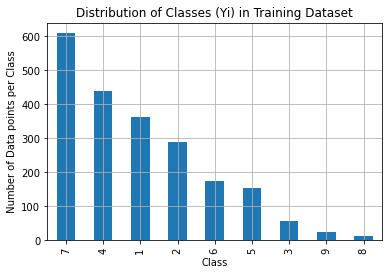

In [271]:
my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel(' Number of Data points per Class ')
plt.title('Distribution of Classes (Yi) in Training Dataset')
plt.grid()
#plt.savefig("imbalance.png")
plt.show()

Let's look at distribution in form of percentage

In [272]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of Observations for Class', i+1, ':',
          train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 2), '%)')

Number of Observations for Class 1 : 609 ( 28.67 %)
Number of Observations for Class 2 : 439 ( 20.67 %)
Number of Observations for Class 3 : 363 ( 17.09 %)
Number of Observations for Class 4 : 289 ( 13.61 %)
Number of Observations for Class 5 : 176 ( 8.29 %)
Number of Observations for Class 6 : 155 ( 7.3 %)
Number of Observations for Class 7 : 57 ( 2.68 %)
Number of Observations for Class 8 : 24 ( 1.13 %)
Number of Observations for Class 9 : 12 ( 0.56 %)


Let's visualize the same for test set

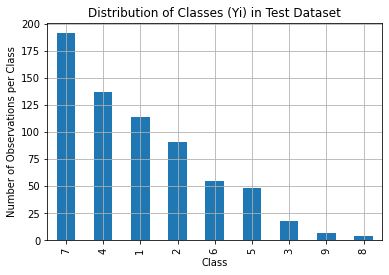

In [273]:
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Number of Observations per Class')
plt.title('Distribution of Classes (Yi) in Test Dataset')
plt.grid()
plt.show()

Again Let's look at distribution of test data in the form of percentage

In [274]:
sorted_yi = np.argsort(-test_class_distribution.values)
for j in sorted_yi:
    print('Number of Observations for Class', j+1, ':',
          test_class_distribution.values[j], '(', np.round((test_class_distribution.values[j]/test_df.shape[0]*100), 2), '%)')

Number of Observations for Class 1 : 191 ( 28.72 %)
Number of Observations for Class 2 : 137 ( 20.6 %)
Number of Observations for Class 3 : 114 ( 17.14 %)
Number of Observations for Class 4 : 91 ( 13.68 %)
Number of Observations for Class 5 : 55 ( 8.27 %)
Number of Observations for Class 6 : 48 ( 7.22 %)
Number of Observations for Class 7 : 18 ( 2.71 %)
Number of Observations for Class 8 : 7 ( 1.05 %)
Number of Observations for Class 9 : 4 ( 0.6 %)


Let's visualize for cross validation set

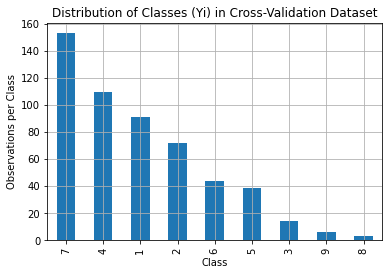

In [275]:
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per Class')
plt.title('Distribution of Classes (Yi) in Cross-Validation Dataset')
plt.grid()
plt.show()

 Let's look at distribution of cv data in the form of percentage

In [276]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of Observations for Class', i+1, ':',
          cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 2), '%)')

Number of Observations for Class 1 : 153 ( 28.76 %)
Number of Observations for Class 2 : 110 ( 20.68 %)
Number of Observations for Class 3 : 91 ( 17.11 %)
Number of Observations for Class 4 : 72 ( 13.53 %)
Number of Observations for Class 5 : 44 ( 8.27 %)
Number of Observations for Class 6 : 39 ( 7.33 %)
Number of Observations for Class 7 : 14 ( 2.63 %)
Number of Observations for Class 8 : 6 ( 1.13 %)
Number of Observations for Class 9 : 3 ( 0.56 %)


Now question is because we need log-loss as final evaluation metrics how do we say that model we are going to build will be good model. For doing this we will build a random model and will evaluate log loss. Our model should return lower log loss value than this.

### Building a baseline random model

Ok, so we need to generate 9 random numbers because we have 9 class such that their sum must be equal to 1 because sum of Probablity of all 9 classes must be equivalent to 1.

In [277]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

In [278]:
# Creating an array with same size as Test Dataset
cv_y_pred = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rnd_p = np.random.rand(1,9)
    cv_y_pred[i] = ((rnd_p/sum(sum(rnd_p)))[0])
print("Log Loss on Cross Validation Dataset - Random Baseline Model",log_loss(y_cv,cv_y_pred, eps=1e-15))

Log Loss on Cross Validation Dataset - Random Baseline Model 2.4789185141296617


In [279]:
# Error on Test-Set.
# Creating an array with same size as Test Dataset
pred_y_test = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rnd_p = np.random.rand(1,9)
    pred_y_test[i] = ((rnd_p/sum(sum(rnd_p)))[0])
print("Log Loss on Test Dataset - Random Baseline Model",log_loss(y_test,pred_y_test, eps=1e-15))


Log Loss on Test Dataset - Random Baseline Model 2.421002533558677


In [280]:
# Lets get the index of max probablity
y_pred =np.argmax(pred_y_test, axis=1)

In [281]:
# Lets see the output. these will be 665 values present in test dataset
y_pred

array([7, 2, 1, 5, 0, 8, 4, 1, 3, 6, 4, 1, 8, 2, 8, 5, 3, 3, 7, 8, 8, 7,
       1, 8, 8, 1, 4, 2, 5, 6, 3, 8, 7, 0, 4, 0, 5, 6, 4, 6, 4, 3, 6, 8,
       8, 5, 2, 7, 5, 7, 7, 3, 8, 4, 4, 4, 4, 2, 8, 6, 6, 0, 1, 5, 1, 5,
       4, 2, 0, 8, 8, 5, 5, 2, 6, 8, 0, 6, 1, 2, 4, 1, 5, 3, 0, 1, 3, 7,
       4, 3, 2, 0, 1, 8, 0, 8, 2, 5, 2, 4, 5, 7, 1, 5, 1, 3, 2, 7, 1, 8,
       8, 3, 1, 1, 2, 3, 1, 1, 4, 0, 0, 2, 3, 4, 1, 1, 0, 1, 4, 4, 7, 6,
       8, 7, 4, 5, 1, 7, 5, 6, 7, 2, 4, 0, 8, 2, 5, 4, 5, 2, 8, 3, 5, 1,
       1, 1, 4, 8, 7, 3, 8, 3, 1, 0, 3, 3, 0, 7, 4, 0, 0, 2, 1, 2, 5, 3,
       6, 2, 5, 4, 5, 0, 2, 6, 0, 2, 5, 6, 8, 6, 6, 3, 8, 2, 1, 7, 0, 6,
       5, 8, 8, 0, 8, 1, 4, 1, 3, 6, 8, 1, 6, 6, 4, 4, 8, 2, 3, 2, 7, 4,
       2, 5, 2, 1, 4, 7, 1, 1, 7, 7, 8, 1, 5, 5, 2, 2, 6, 2, 4, 4, 7, 1,
       2, 1, 0, 5, 0, 6, 3, 4, 3, 4, 0, 2, 3, 3, 7, 2, 0, 5, 2, 7, 3, 3,
       4, 3, 3, 2, 0, 7, 4, 2, 3, 1, 3, 3, 6, 7, 4, 7, 7, 5, 6, 6, 2, 3,
       3, 2, 4, 5, 5, 6, 4, 0, 7, 3, 5, 5, 2, 4, 1,

As we can see the index value ranging from 0 to 8. So, lets make it as 1 to 9 we will increase this value by 1.

In [282]:
y_pred = y_pred + 1

### Confusion Matrix

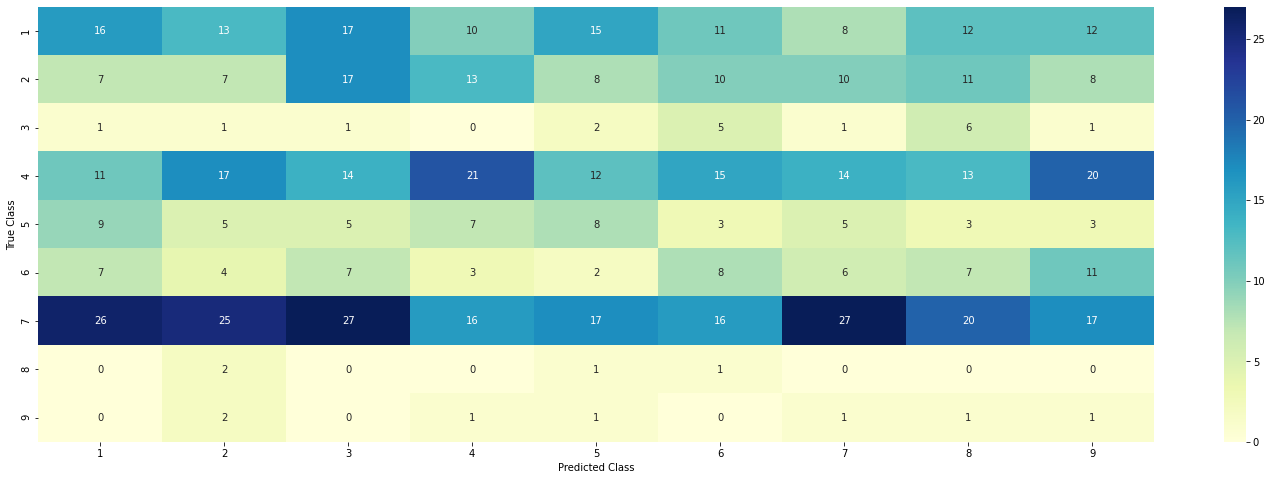

In [283]:
CM = confusion_matrix(y_test, y_pred)

labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(25,8))
sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt=".0f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.savefig("Conf_baseline.jpg")
plt.show()


### Precision matrix

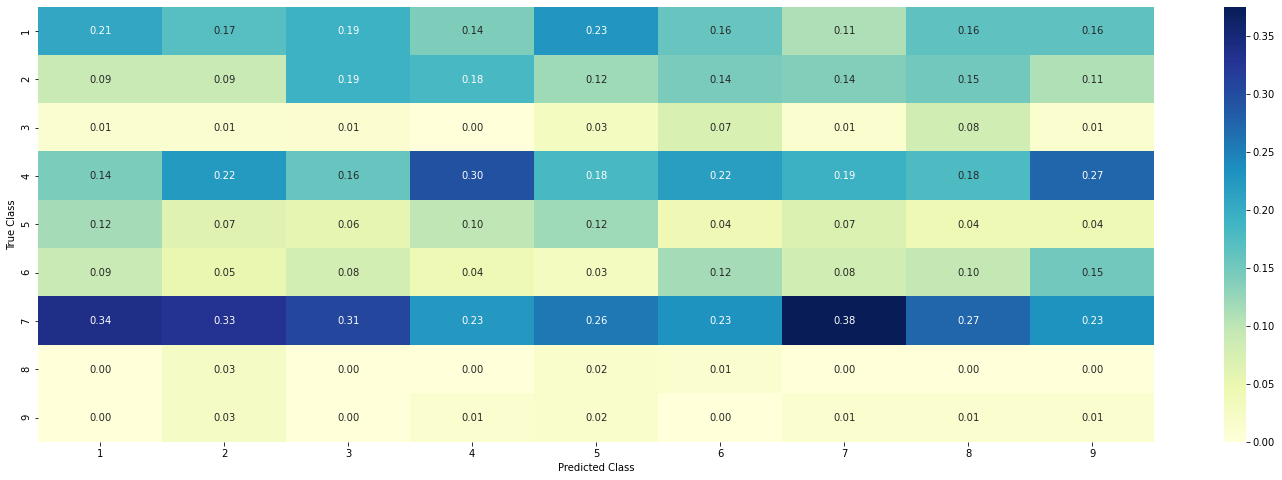

In [284]:
B =(CM/CM.sum(axis=0))

plt.figure(figsize=(25,8))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

### Recall matrix

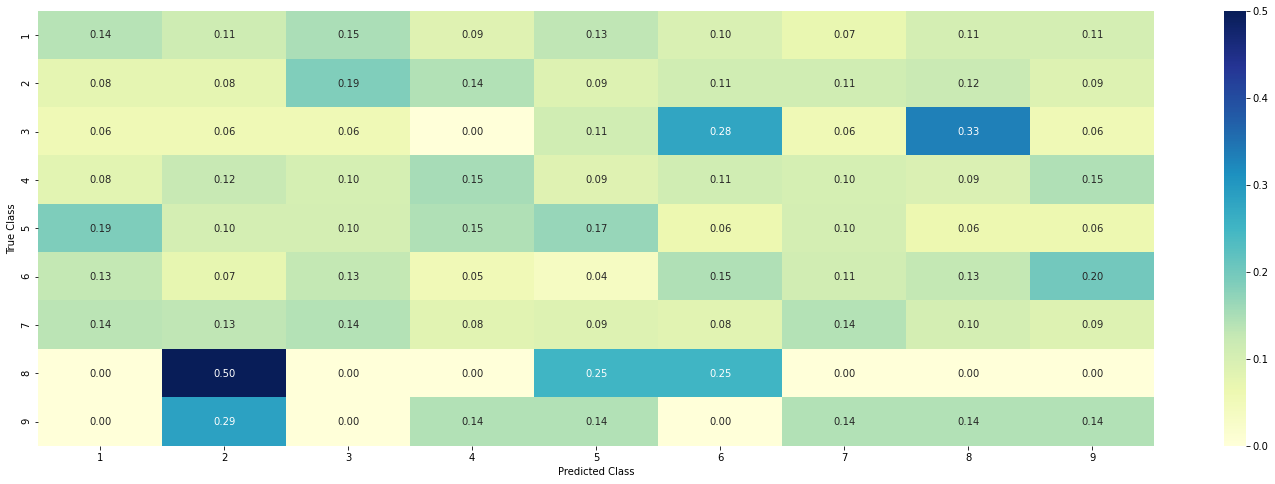

In [285]:
A =(((CM.T)/(CM.sum(axis=1))).T)
plt.figure(figsize=(25,8))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

### Evaluating Categorical features
we have three categorical feature values:
    * Gene
    * Variation
    * Text

### 1.Evaluating Gene Column
Now we will look at each independent column to make sure its relavent for my target variable but the question is, how? Let's understand with our first column Gene which is categorial in nature.

So, lets explore column Gene and lets look at its distribution.

In [286]:
genes_unique = train_df['Gene'].value_counts()
print('Number of Unique Genes :', genes_unique.shape[0])
# the top 10 genes that occured most
print(genes_unique.head(10))

Number of Unique Genes : 227
BRCA1     170
TP53      105
EGFR       89
PTEN       88
BRCA2      83
KIT        61
BRAF       58
ERBB2      48
ALK        46
PDGFRA     40
Name: Gene, dtype: int64


Lets see the number of unique values present in gene

In [287]:
genes_unique.shape[0]

227

Lets look at the comulative distribution of unique Genes values

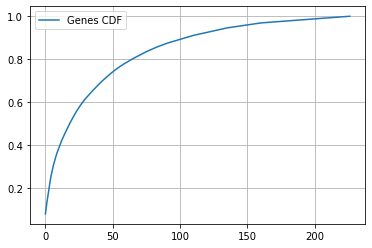

In [288]:
s = sum(genes_unique.values);
gs = genes_unique.values/s;
cgs = np.cumsum(gs)
plt.plot(cgs,label='Genes CDF')
plt.grid()
plt.legend()
plt.savefig("cum_gene.png")
plt.show()

So, now we need to convert these categorical variable to appropirate format which my machine learning algorithm will be able to take as an input.

So we have 2 techniques to deal with it. 

<ol>
    <li><b>One-hot encoding</b> </li>
    <li><b>Response Encoding (Mean imputation)</b> </li>
</ol>

Let's use both of them to see which one work the best. So lets start encoding using one hot encoder

In [289]:
# Using one-hot encoding for Gene features
gene_vect = CountVectorizer()
genes_feature_1hot_train = gene_vect.fit_transform(train_df['Gene'])
genes_feature_1hot_test = gene_vect.transform(test_df['Gene'])
genes_feature_1hot_cv = gene_vect.transform(cv_df['Gene'])

Let's check the number of column generated after one hot encoding.One hot encoding will always return higher number of columns

In [290]:
genes_feature_1hot_train.shape

(2124, 226)

In [291]:
#column names after one-hot encoding for Gene column
gene_vect.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid2',
 'arid5b',
 'asxl2',
 'atm',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',

Now, lets also create Response encoding columns for Gene column

In [292]:
# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            

            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [293]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

Let's look at columns after applying response encoding. We must be having 9 columns for Gene column after response encoding

In [294]:
train_gene_feature_responseCoding.shape

(2124, 9)

Now, question is how good is Gene column feature to predict my 9 classes. One idea could be that we will build model having only gene column with one hot encoder with simple model like Logistic regression. If log loss with only one column Gene comes out to be better than random model, than this feature is important

In [295]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [296]:
# We will be using SGD classifier
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
log_error_cv=[]
for i in alpha:
    clsf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clsf.fit(genes_feature_1hot_train, y_train)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(genes_feature_1hot_train, y_train)
    predict_y = sig_clsf.predict_proba(genes_feature_1hot_cv)
    log_error_cv.append(log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))
    print('alpha = ', i, " : Log Loss = ",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))

alpha =  1e-05  : Log Loss =  1.249474753671464
alpha =  0.0001  : Log Loss =  1.2310031408587354
alpha =  0.001  : Log Loss =  1.275483878461247
alpha =  0.01  : Log Loss =  1.3856219024602154
alpha =  0.1  : Log Loss =  1.4662589059559945
alpha =  1  : Log Loss =  1.495662774317549


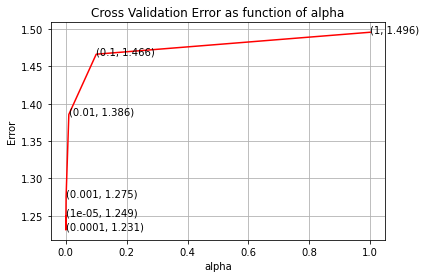

In [297]:
# Lets plot the same to check the best Alpha value
grf, dfx = plt.subplots()
dfx.plot(alpha, log_error_cv,c='r')
for im, ctx in enumerate(np.round(log_error_cv,3)):
    dfx.annotate((alpha[im],np.round(ctx,3)), (alpha[im],log_error_cv[im]))
plt.grid()
plt.title("Cross Validation Error as function of alpha")
plt.xlabel("alpha")
plt.ylabel("Error")
plt.show()

In [298]:
# Lets use best alpha value as we can see from above graph and compute log loss
opt_alpha = np.argmin(log_error_cv)
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(genes_feature_1hot_train, y_train)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(genes_feature_1hot_train, y_train)

predict_y = sig_clsf.predict_proba(genes_feature_1hot_train)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the training dataset is:",log_loss(y_train, predict_y, labels=clsf.classes_, eps=1e-15))

predict_y = sig_clsf.predict_proba(genes_feature_1hot_test)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the test dataset is:",log_loss(y_test, predict_y, labels=clsf.classes_, eps=1e-15))

predict_y = sig_clsf.predict_proba(genes_feature_1hot_cv)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the cross validation dataset is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))


For the best alpha =  0.0001 . The log loss on the training dataset is: 0.9825377607712589
For the best alpha =  0.0001 . The log loss on the test dataset is: 1.1984722999497637
For the best alpha =  0.0001 . The log loss on the cross validation dataset is: 1.2310031408587354


### Checking the stabiliy of the model
 Meaning We check how many values are overlapping between train, test or between CV and train,the more the overlapping the better is the stability of the model

In [299]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [300]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 513 out of  532 : 96.42857142857143


### 2.Evaluating Variation column
Variation is also a categorical variable so we have to deal in same way like we have done for ***Gene*** column. We will again get the one hot encoder and response enoding variable for variation column.

In [301]:
unique_vars = train_df['Variation'].value_counts()
print('Number of Unique Gene Variations :', unique_vars.shape[0])
# the top 10 variations that occured most
print(unique_vars.head(10))

Number of Unique Gene Variations : 1923
Truncating_Mutations    62
Amplification           56
Deletion                43
Fusions                 22
Overexpression           5
G12V                     4
Q61H                     3
R173C                    2
E17K                     2
G12A                     2
Name: Variation, dtype: int64


Lets look at the comulative distribution of unique variation values

[0.02919021 0.05555556 0.07580038 ... 0.99905838 0.99952919 1.        ]


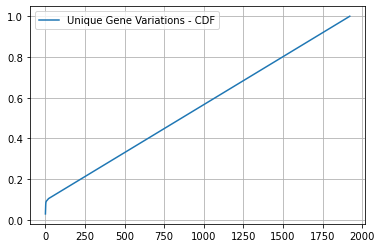

In [302]:
suv = sum(unique_vars.values);
hsuv = unique_vars.values/suv;
csuv = np.cumsum(hsuv)
print(csuv)
plt.plot(csuv,label='Unique Gene Variations - CDF')
plt.grid()
plt.legend()
#plt.savefig("cumu_var.png")
plt.show()

Lets convert the variation column using one hot encoder column

In [303]:
# one-hot encoding of variation feature.
variation_vect = CountVectorizer()
variation_feature_1hot_train = variation_vect.fit_transform(train_df['Variation'])
variation_feature_1hot_test = variation_vect.transform(test_df['Variation'])
variation_feature_1hot_cv = variation_vect.transform(cv_df['Variation'])

Lets look at shape of one hot encoder column for variation

In [304]:
variation_feature_1hot_train.shape

(2124, 1954)

Lets do the same for variation column and generate response encoding for the same

In [305]:
# alpha is used for laplace smoothing
alpha = 1

# get respose coding for train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))

# get respose coding for  test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))

# get respose coding for cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

Lets look at the shape of this response encoding result

In [306]:
train_variation_feature_responseCoding.shape

(2124, 9)

Lets again build the model with only column name of variation column

In [307]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [308]:
# We will be using SGD classifier
# We will also be using Calibrated Classifier to get the result into probablity format t be used for log loss
log_error_cv=[]
for i in alpha:
    clsf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clsf.fit(variation_feature_1hot_train, y_train)
    
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(variation_feature_1hot_train, y_train)
    y_pred = sig_clsf.predict_proba(variation_feature_1hot_cv)
    
    log_error_cv.append(log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))
    print('alpha = ', i, "; Log Loss = ",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))

alpha =  1e-05 ; Log Loss =  1.6886942709635522
alpha =  0.0001 ; Log Loss =  1.6894994412285813
alpha =  0.001 ; Log Loss =  1.696575190885705
alpha =  0.01 ; Log Loss =  1.7018906847104165
alpha =  0.1 ; Log Loss =  1.7106717720190914
alpha =  1 ; Log Loss =  1.7124020505686255


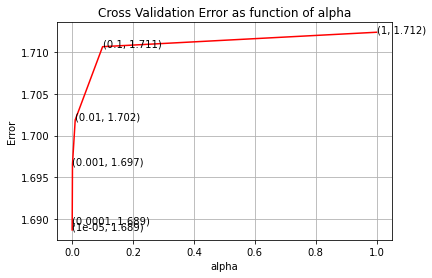

In [309]:

grf, dfx = plt.subplots()
dfx.plot(alpha, log_error_cv,c='r')
for im, ctx in enumerate(np.round(log_error_cv,3)):
    dfx.annotate((alpha[im],np.round(ctx,3)), (alpha[im],log_error_cv[im]))
plt.grid()
plt.title("Cross Validation Error as function of alpha")
plt.xlabel("alpha")
plt.ylabel("Error")
plt.show()

In [310]:
# Lets use best alpha value as we can see from above graph and compute log loss
opt_alpha = np.argmin(log_error_cv)
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(variation_feature_1hot_train, y_train)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(variation_feature_1hot_train, y_train)

y_pred = sig_clsf.predict_proba(variation_feature_1hot_train)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the training dataset is:",log_loss(y_train, y_pred, labels=clsf.classes_, eps=1e-15))

y_pred = sig_clsf.predict_proba(variation_feature_1hot_test)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the test dataset is:",log_loss(y_test, y_pred, labels=clsf.classes_, eps=1e-15))

y_pred = sig_clsf.predict_proba(variation_feature_1hot_cv)
print('For the best alpha = ', alpha[opt_alpha], ". The log loss on the cross validation dataset is:",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))


For the best alpha =  1e-05 . The log loss on the training dataset is: 0.5450770331008444
For the best alpha =  1e-05 . The log loss on the test dataset is: 1.7244121577152585
For the best alpha =  1e-05 . The log loss on the cross validation dataset is: 1.6886942709635522


In [311]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [312]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

1. In test data 63 out of 665 : 9.473684210526317
2. In cross validation data 56 out of  532 : 10.526315789473683


### 3.Evaluating Text column

In [313]:
# Create the function to get the count of each word i.e how many times each word has occured
# Algorithm:
#        cls_text is a data frame
#        for every row in data fram consider the 'TEXT'
#        split the words by space
#        make a dict with those words
#        increment its count whenever we see that word
#  return count_of_word.dict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [314]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [315]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_txt_feature_1hot = text_vectorizer.fit_transform(train_df['TEXT'])

# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_txt_feature_1hot.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in training dataset :", len(train_text_features))

Total number of unique words in training dataset : 53170


In [316]:
#<----------------------DANGER-----------------------Dont Print anything
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [317]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [318]:

# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [319]:
#Normalize every feature

train_txt_feature_1hot = normalize(train_txt_feature_1hot, axis=0)

# we use the same vectorizer that was trained on train data
test_txt_feature_1hot = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_txt_feature_1hot = normalize(test_txt_feature_1hot, axis=0)

# we use the same vectorizer that was trained on train data
cv_txt_feature_1hot = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_txt_feature_1hot = normalize(cv_txt_feature_1hot, axis=0)

In [320]:

sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [321]:
# Number of words for a given frequency.
#print(Counter(sorted_text_occur))

In [322]:
y_train.mean()

4.366290018832392

Lets build the model with only **text** column

In [323]:
log_error_cv=[]
for i in alpha:
    clsf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clsf.fit(train_txt_feature_1hot, y_train)
    
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_txt_feature_1hot, y_train)
    predict_y = sig_clsf.predict_proba(cv_txt_feature_1hot)
    log_error_cv.append(log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.2597148130773486
For values of alpha =  0.0001 The log loss is: 1.0856975226572074
For values of alpha =  0.001 The log loss is: 1.0840411404336294
For values of alpha =  0.01 The log loss is: 1.2132496093371257
For values of alpha =  0.1 The log loss is: 1.4788564668330362
For values of alpha =  1 The log loss is: 1.6771264758612006


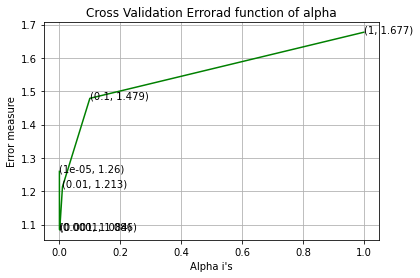

In [324]:
fig, dfx = plt.subplots()
dfx.plot(alpha, log_error_cv,c='g')
for i, txt in enumerate(np.round(log_error_cv,3)):
    dfx.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_cv[i]))
plt.grid()
plt.title("Cross Validation Errorad function of alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [325]:
opt_alpha = np.argmin(log_error_cv)
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(train_txt_feature_1hot, y_train)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_txt_feature_1hot, y_train)

predict_y = sig_clsf.predict_proba(train_txt_feature_1hot)
print('For optimal alpha value = ', alpha[opt_alpha], "The training log loss is:",log_loss(y_train, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(cv_txt_feature_1hot)
print('For optimal alpha value = ', alpha[opt_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(test_txt_feature_1hot)
print('For optimal alpha value = ', alpha[opt_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clsf.classes_, eps=1e-15))


For optimal alpha value =  0.001 The training log loss is: 0.6587409178378927
For optimal alpha value =  0.001 The cross validation log loss is: 1.0840411404336294
For optimal alpha value =  0.001 The test log loss is: 1.24044272774481


Lets check the overlap of text data

In [326]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [327]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.241 % of word of test data appeared in train data
96.834 % of word of Cross Validation appeared in train data


***By doing the above analysis all the three features are going to important for our model buliding***

## Data prepration for Machine Learning models

Lets create few functions which we will be using later

In [328]:
# Create a function reporting log-loss
def rep_log_loss(train_x, train_y, test_x, test_y,  clsf):
    clsf.fit(train_x, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(test_x)
    return log_loss(test_y, sig_clsf_probs, eps=1e-15)


In [329]:
# This function plots the confusion matrices given y_i, y_i_hat.
def confusion_mat_plot(test_y, predict_y):
    CM = confusion_matrix(test_y, predict_y)
    
    AP =(((CM.T)/(CM.sum(axis=1))).T)
    
    BP =(CM/CM.sum(axis=0)) 
    pts = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion Matrix", "-"*20)
    plt.figure(figsize=(25,8))
    sns.heatmap(CM, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=pts, yticklabels=pts)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    #plt.savefig("confusion_mat", dpi =500)
    plt.show()
    

    print("-"*20, "Precision Matrix", "-"*20)
    plt.figure(figsize=(25,8))
    sns.heatmap(BP, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=pts, yticklabels=pts)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    #plt.savefig("precision_mat", dpi =500)
    plt.show()
    
    
    # representing B in heatmap format
    print("-"*20, "Recall Matrix", "-"*20)
    plt.figure(figsize=(25,8))
    sns.heatmap(AP, annot=True, cmap="YlGnBu", fmt=".2f", xticklabels=pts, yticklabels=pts)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    #plt.savefig("recall_mat", dpi =500)
    plt.show()
    


def conf_mat_pred_plot(train_x, train_y,test_x, test_y, clsf):
    clsf.fit(train_x, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x, train_y)
    y_pred = sig_clsf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log Loss :",log_loss(test_y, sig_clsf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of Mis-Classified Points :", np.count_nonzero((y_pred- test_y))/test_y.shape[0])
    confusion_mat_plot(test_y, y_pred)

In [330]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not for interpretability
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

### Combining all 3 features together

After various encodings and imputations

In [331]:
# merging gene, variance and text features

# building train, test and cross validation data sets

train_gene_var_onehotCoding = hstack((genes_feature_1hot_train,variation_feature_1hot_train))
test_gene_var_onehotCoding = hstack((genes_feature_1hot_test,variation_feature_1hot_test))
cv_gene_var_onehotCoding = hstack((genes_feature_1hot_cv,variation_feature_1hot_cv))

train_x_onehotCoding = hstack((genes_feature_1hot_train, train_txt_feature_1hot)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((genes_feature_1hot_test, test_txt_feature_1hot)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((genes_feature_1hot_cv, cv_txt_feature_1hot)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [332]:
print("Feature One Hot Encoding :")
print("(Data Pts, Features) in Training Dataset = ", train_x_onehotCoding.shape)
print("(Data Pts, Features) in Test Dataset = ", test_x_onehotCoding.shape)
print("(Data Pts, Features) in Cross Calidation Dataset =", cv_x_onehotCoding.shape)

Feature One Hot Encoding :
(Data Pts, Features) in Training Dataset =  (2124, 53396)
(Data Pts, Features) in Test Dataset =  (665, 53396)
(Data Pts, Features) in Cross Calidation Dataset = (532, 53396)


In [333]:
print(" Feature Response Encoding :")
print("(Data Pts, Features) in Training Dataset = ", train_x_responseCoding.shape)
print("(Data Pts, Features) in Test Dataset = ", test_x_responseCoding.shape)
print("(Data Pts, Features) in Cross Calidation Dataset =", cv_x_responseCoding.shape)

 Feature Response Encoding :
(Data Pts, Features) in Training Dataset =  (2124, 27)
(Data Pts, Features) in Test Dataset =  (665, 27)
(Data Pts, Features) in Cross Calidation Dataset = (532, 27)


## Building Machine Learning model
Lets start the first model which is most suitable when we have lot of text column data. So, we will start with Naive Bayes.

## 1.Naive Bayes

Since this is a multiclass classification problem we MultinomialNaiveBayes classification algorithm

In [334]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
log_error_cv = []
for i in alpha:
    
    clsf = MultinomialNB(alpha=i) #MultinomialNB classifier for multiclass problem
    clsf.fit(train_x_onehotCoding, train_y)
    
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding) #get the o/p as prob using predict_prob
    log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Alpha =", i, "Log Loss :",log_loss(cv_y, sig_clsf_probs)) 

Alpha = 1e-05 Log Loss : 1.2765512923220266
Alpha = 0.0001 Log Loss : 1.2784297714830961
Alpha = 0.001 Log Loss : 1.281865032696255
Alpha = 0.1 Log Loss : 1.2902676514291749
Alpha = 1 Log Loss : 1.2602370917123291
Alpha = 10 Log Loss : 1.4151230242121746
Alpha = 100 Log Loss : 1.4247611657848864
Alpha = 1000 Log Loss : 1.3725105550703274


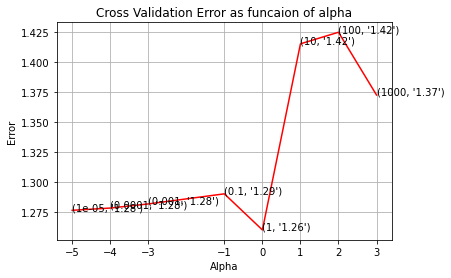

In [335]:
dfg, dax = plt.subplots()
dax.plot(np.log10(alpha), log_error_cv,c='r')
for im, clt in enumerate(np.round(log_error_cv,2)):
    dax.annotate((alpha[im],str(clt)), (np.log10(alpha[im]),log_error_cv[im]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error as funcaion of alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [336]:
opt_alpha = np.argmin(log_error_cv)
clsf = MultinomialNB(alpha=alpha[opt_alpha])
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)


y_pred = sig_clsf.predict_proba(train_x_onehotCoding)
print('For best alpha = ', alpha[opt_alpha], "Log Loss Training:",log_loss(y_train, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(cv_x_onehotCoding)
print('For best alpha = ', alpha[opt_alpha], "Log Loss Cross-Validation:",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(test_x_onehotCoding)
print('For best alpha = ', alpha[opt_alpha], "Log Loss Test:",log_loss(y_test, y_pred, labels=clsf.classes_, eps=1e-15))


For best alpha =  1 Log Loss Training: 0.9152849667414561
For best alpha =  1 Log Loss Cross-Validation: 1.2602370917123291
For best alpha =  1 Log Loss Test: 1.3233014065877884


Testing our Naive Bayes model with best found value of alpha on testing data

Log Loss : 1.2602370917123291
Number of Mis-Classified point : 0.39473684210526316


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


-------------------- Confusion Matrix --------------------


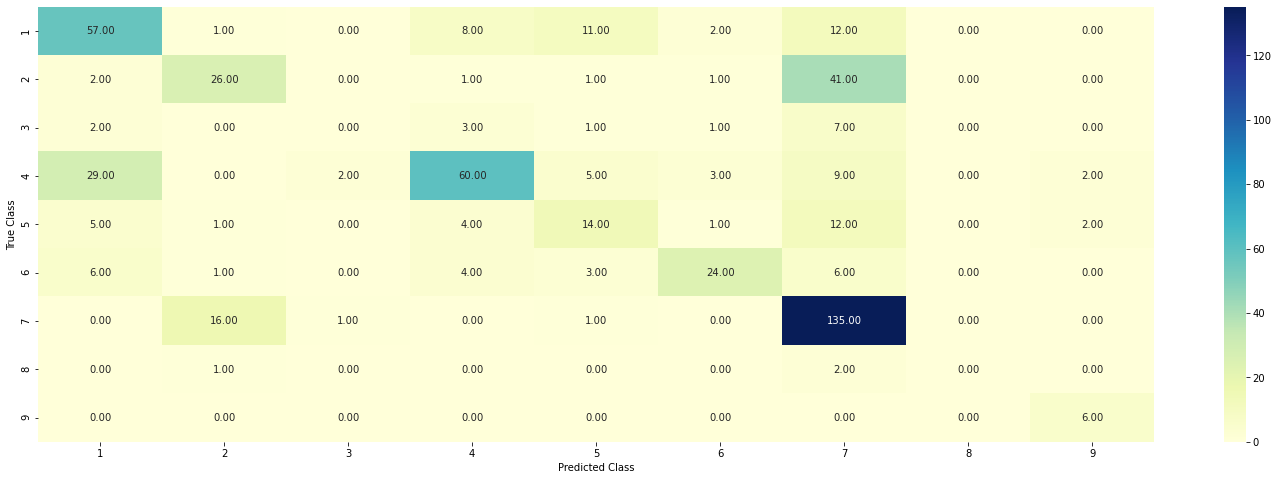

-------------------- Precision Matrix --------------------


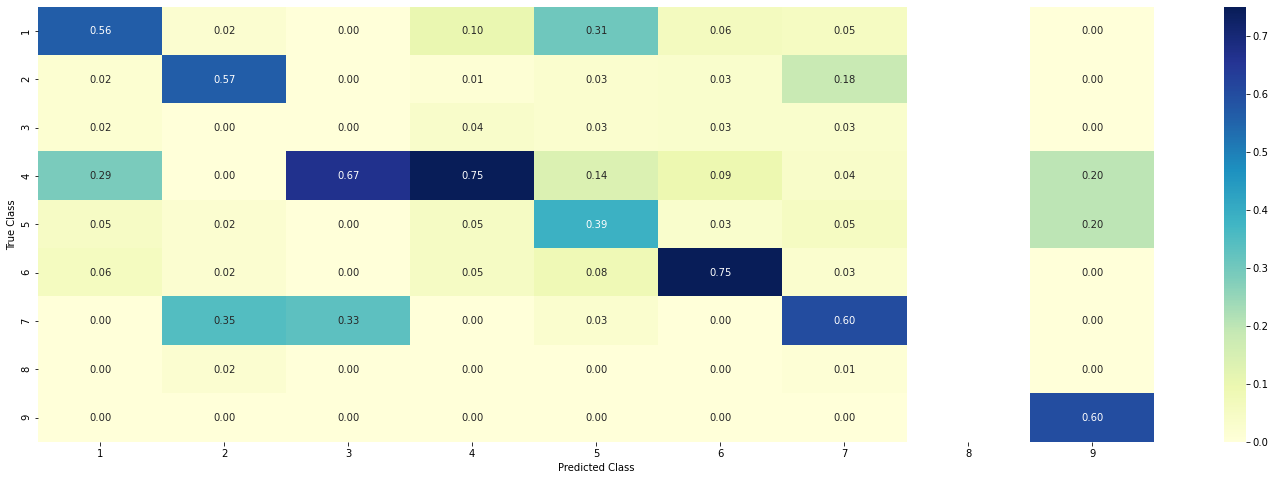

-------------------- Recall Matrix --------------------


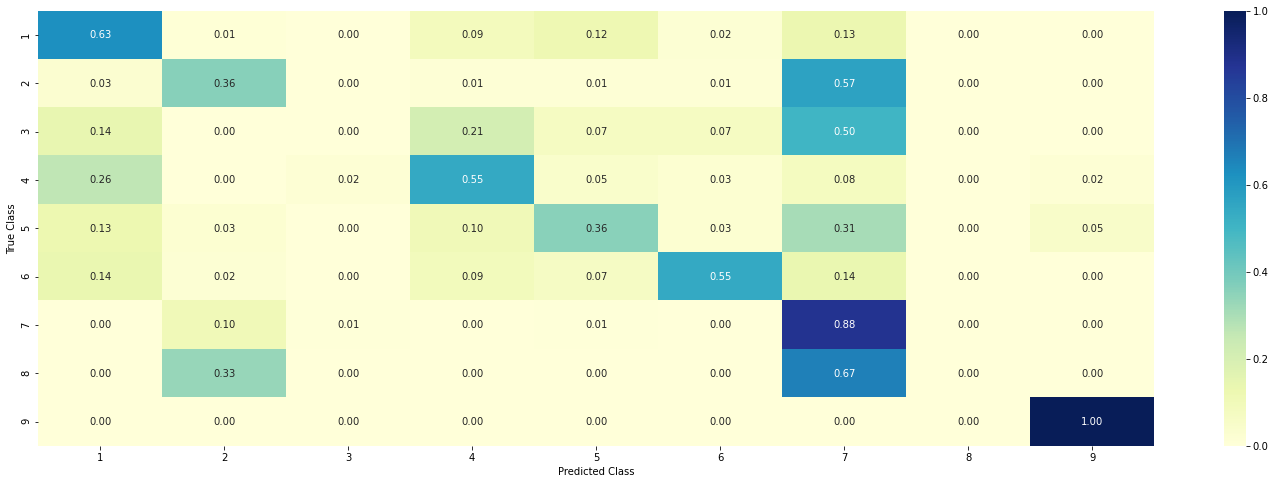

In [337]:
clsf = MultinomialNB(alpha=alpha[opt_alpha])
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)
sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding)

print("Log Loss :",log_loss(cv_y, sig_clsf_probs))
print("Number of Mis-Classified point :", np.count_nonzero((sig_clsf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
confusion_mat_plot(cv_y, sig_clsf.predict(cv_x_onehotCoding.toarray()))

#### Accracy = 1 - Number of misclassified points

### Interpretability of our model

In [338]:
test_point_index = 2
no_feature = 100
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0873 0.6121 0.0217 0.1016 0.0479 0.042  0.0766 0.0066 0.0043]]
Actual Class : 2
--------------------------------------------------
42 Text feature [37] present in test data point [True]
63 Text feature [model] present in test data point [True]
83 Text feature [per] present in test data point [True]
Out of the top  100  features  3 are present in query point


As seen above  test point at index 2 is predicted to be belonging to the class 7
as the probability is the highest at .5356 (53%)

Lets look at one more point

In [339]:
test_point_index = 104
no_feature = 100
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0797 0.0833 0.0198 0.0922 0.0437 0.0383 0.633  0.006  0.0039]]
Actual Class : 7
--------------------------------------------------
68 Text feature [hki] present in test data point [True]
Out of the top  100  features  1 are present in query point


# -------------------------------------------------------------------

# 2. K-NN Classification

In [382]:
alpha = [2, 5, 25, 30, 40, 50, 99]
log_error_cv= []
for i in alpha:
    print("for alpha =", i)
    clsf = KNeighborsClassifier(n_neighbors=i)
    clsf.fit(train_x_responseCoding, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x_responseCoding, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(cv_x_responseCoding)
    log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clsf_probs))

for alpha = 2
Log Loss : 1.1324379355219174
for alpha = 5
Log Loss : 1.074623293753578
for alpha = 25
Log Loss : 1.0915572837369045
for alpha = 30
Log Loss : 1.0963957378774352
for alpha = 40
Log Loss : 1.110810855915241
for alpha = 50
Log Loss : 1.1308250638771733
for alpha = 99
Log Loss : 1.141842114487445


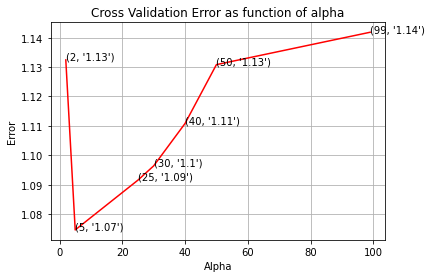

In [383]:
dfg, dax = plt.subplots()
dax.plot(alpha, log_error_cv,c='r')
for im, clt in enumerate(np.round(log_error_cv,2)):
    dax.annotate((alpha[im],str(clt)), (alpha[im],log_error_cv[im]))
plt.grid()
plt.title("Cross Validation Error as function of alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [384]:
opt_alpha = np.argmin(log_error_cv)
clsf = KNeighborsClassifier(n_neighbors=alpha[opt_alpha])
clsf.fit(train_x_responseCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_responseCoding, train_y)

y_pred = sig_clsf.predict_proba(train_x_responseCoding)
print('For the best alpha = ', alpha[opt_alpha], ", Log Loss on Training Dataset:",log_loss(y_train, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(cv_x_responseCoding)
print('For the best alpha = ', alpha[opt_alpha], ", Log Loss on Cross-Validation Dataset:",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(test_x_responseCoding)
print('For the best alpha = ', alpha[opt_alpha], ", Log Loss on Test Dataset:",log_loss(y_test, y_pred, labels=clsf.classes_, eps=1e-15))


For the best alpha =  5 , Log Loss on Training Dataset: 0.4523007559301016
For the best alpha =  5 , Log Loss on Cross-Validation Dataset: 1.074623293753578
For the best alpha =  5 , Log Loss on Test Dataset: 1.1118555323411787


Let's test it on testing dataset with our best alpha value

Log Loss : 1.074623293753578
Number of Mis-Classified Points : 0.37969924812030076
-------------------- Confusion Matrix --------------------


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


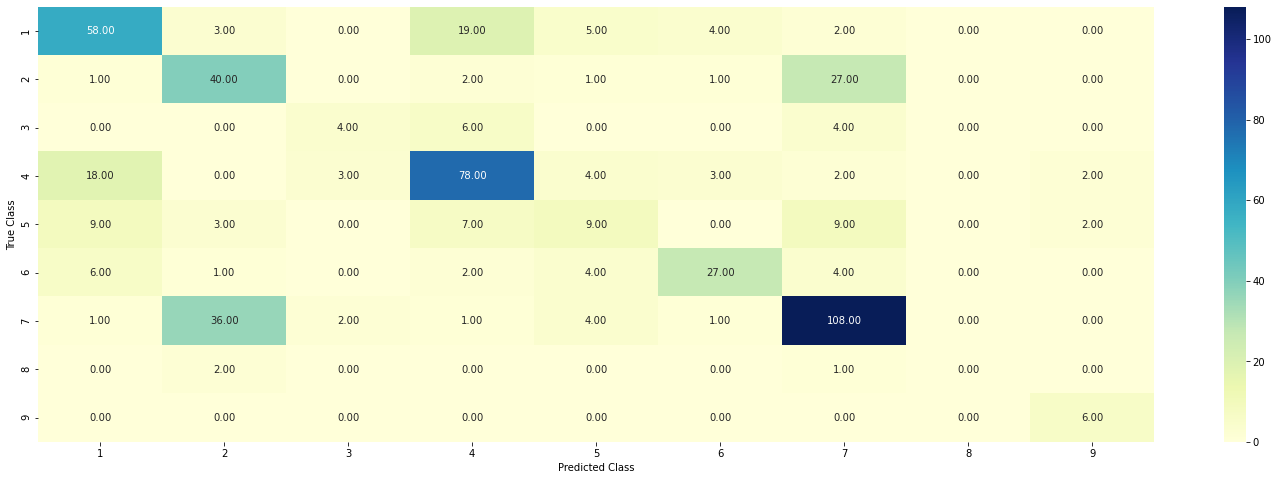

-------------------- Precision Matrix --------------------


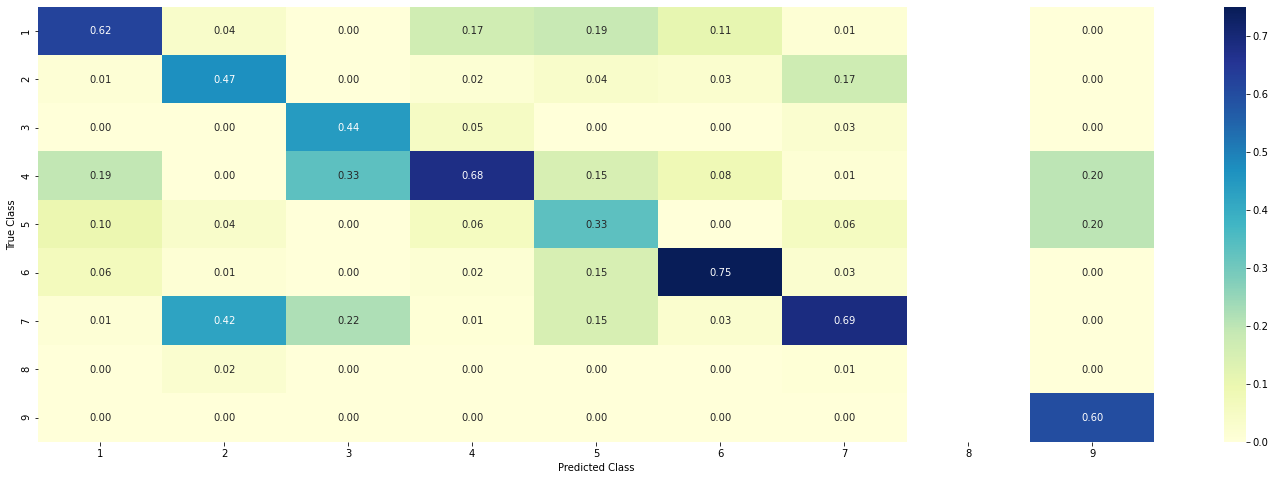

-------------------- Recall Matrix --------------------


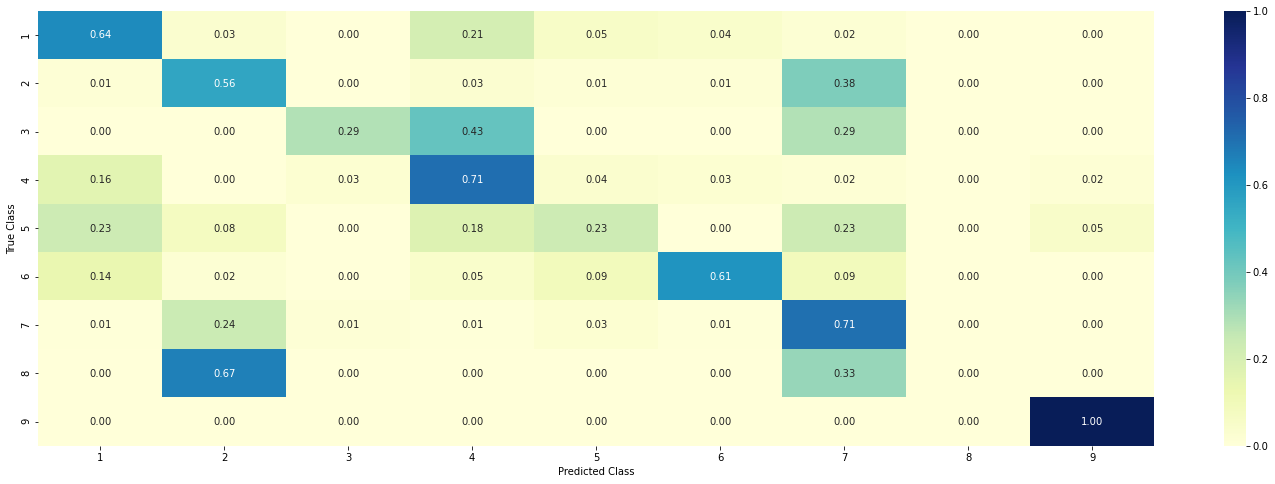

In [385]:
clsf = KNeighborsClassifier(n_neighbors=alpha[opt_alpha])
conf_mat_pred_plot(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clsf)

In [386]:
# Lets look at few test points
clsf = KNeighborsClassifier(n_neighbors=alpha[opt_alpha])
clsf.fit(train_x_responseCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clsf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clsf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[opt_alpha])
print("The ",alpha[opt_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 4
Actual Class : 2
The  5  nearest neighbours of the test points belongs to classes [2 2 2 2 2]
Fequency of nearest points : Counter({2: 5})


In [387]:
clsf = KNeighborsClassifier(n_neighbors=alpha[opt_alpha])
clsf.fit(train_x_responseCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clsf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clsf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[opt_alpha])
print("the k value for knn is",alpha[opt_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 1
the k value for knn is 5 and the nearest neighbours of the test points belongs to classes [1 4 1 1 1]
Fequency of nearest points : Counter({1: 4, 4: 1})


# -------------------------------------------------------------------

# 3.Logistic Regression

### Balancing all classes  for improving the model
 As various classes(8 and9) are under represented we use OVERSAMPLING to balance all the classes

In [346]:
alpha = [10 ** x for x in range(-6, 3)]
log_error_cv = []
for i in alpha:
  
    clsf = SGDClassifier(class_weight='balanced', # class_weight helps in balancing the data usimg oversampling
                        alpha=i, penalty='l2', loss='log', random_state=42)
    clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding)
    log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
    
    print( "alpha =", i, " Log Loss :",log_loss(cv_y, sig_clsf_probs)) 


alpha = 1e-06  Log Loss : 1.3530466483202674
alpha = 1e-05  Log Loss : 1.2762774817639115
alpha = 0.0001  Log Loss : 1.086733454365278
alpha = 0.001  Log Loss : 1.064313394516033
alpha = 0.01  Log Loss : 1.1519097488167818
alpha = 0.1  Log Loss : 1.4750659088453693
alpha = 1  Log Loss : 1.6875566737562724
alpha = 10  Log Loss : 1.717956665978252
alpha = 100  Log Loss : 1.7212093298517914


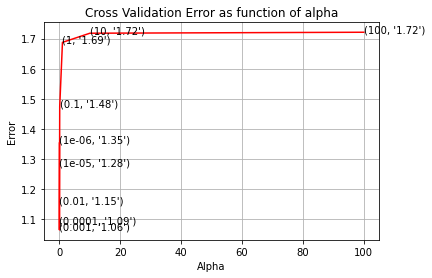

In [347]:
dfg, dax = plt.subplots()
dax.plot(alpha, log_error_cv,c='r')
for im, clt in enumerate(np.round(log_error_cv,2)):
    dax.annotate((alpha[im],str(clt)), (alpha[im],log_error_cv[im]))
plt.grid()
plt.title("Cross Validation Error as function of alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [348]:
opt_alpha = np.argmin(log_error_cv)
clsf = SGDClassifier(class_weight='balanced', alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)

y_pred = sig_clsf.predict_proba(train_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Training:",log_loss(y_train, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(cv_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Cross-Validation:",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(test_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Test:",log_loss(y_test, y_pred, labels=clsf.classes_, eps=1e-15))

For the best alpha =  0.001 Log Loss on Training: 0.5980111704261885
For the best alpha =  0.001 Log Loss on Cross-Validation: 1.064313394516033
For the best alpha =  0.001 Log Loss on Test: 1.2092707401201022


Lets test it on testing data using best alpha value

Log Loss : 1.064313394516033
Number of Mis-Classified Points : 0.34962406015037595
-------------------- Confusion Matrix --------------------


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


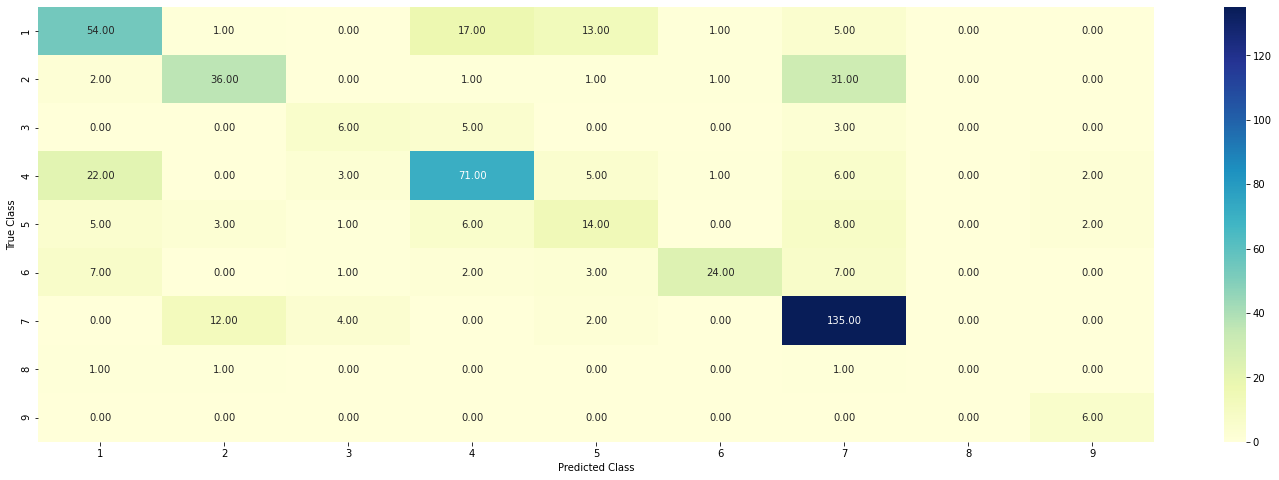

-------------------- Precision Matrix --------------------


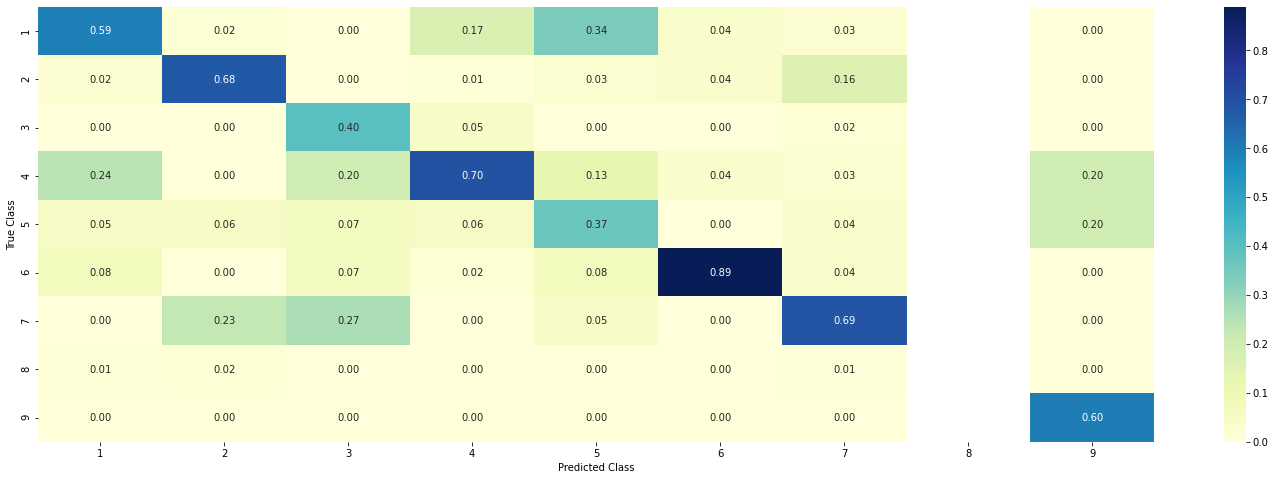

-------------------- Recall Matrix --------------------


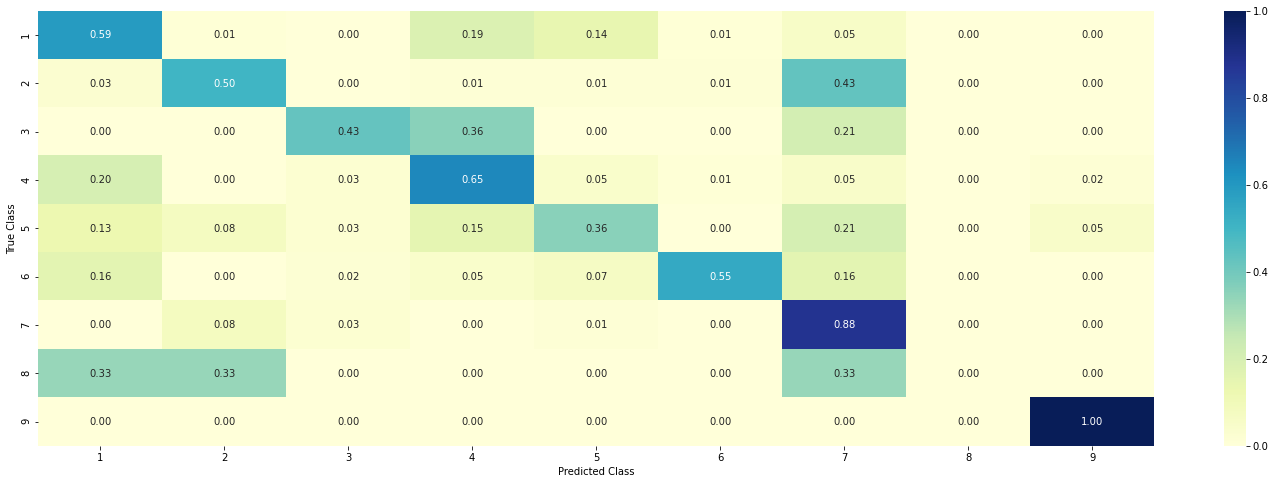

In [349]:
clsf = SGDClassifier(class_weight='balanced', alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
conf_mat_pred_plot(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clsf)

## Feature importance (interpretabilty)

In [350]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [351]:
train_x_onehotCoding.shape, train_y.shape

((2124, 53396), (2124,))

Testing query point and doing interpretability

In [352]:
# from tabulate import tabulate
clsf = SGDClassifier(class_weight='balanced', alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[1.000e-03 9.002e-01 3.000e-04 4.000e-04 9.000e-04 3.100e-03 8.380e-02
  8.200e-03 2.200e-03]]
Actual Class : 2
--------------------------------------------------
24 Text feature [nonmutant] present in test data point [True]
38 Text feature [mechanisms] present in test data point [True]
98 Text feature [researchers] present in test data point [True]
113 Text feature [messenger] present in test data point [True]
157 Text feature [contain] present in test data point [True]
174 Text feature [pattern] present in test data point [True]
179 Text feature [could] present in test data point [True]
193 Text feature [importantly] present in test data point [True]
202 Text feature [penetration] present in test data point [True]
226 Text feature [manuscript] present in test data point [True]
240 Text feature [subcloned] present in test data point [True]
242 Text feature [structures] present in test data point [True]
276 Text feature [made] present

In [353]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.6162 0.0281 0.0046 0.2961 0.0143 0.012  0.0197 0.0044 0.0045]]
Actual Class : 1
--------------------------------------------------
70 Text feature [exhibits] present in test data point [True]
100 Text feature [necessary] present in test data point [True]
161 Text feature [specific] present in test data point [True]
262 Text feature [interestingly] present in test data point [True]
299 Text feature [recognized] present in test data point [True]
320 Text feature [critical] present in test data point [True]
341 Text feature [analyses] present in test data point [True]
Out of the top  500  features  7 are present in query point


## Without class balancing

In [354]:
alpha = [10 ** x for x in range(-6, 1)]
log_error_cv = []
for i in alpha:
    print("for alpha =", i)
    clsf = SGDClassifier(alpha=i,  # here no oversampling done
                        penalty='l2', 
                        loss='log', random_state=42)
    clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding)
    log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clsf_probs)) 


for alpha = 1e-06
Log Loss : 1.32179562745955
for alpha = 1e-05
Log Loss : 1.2784071263642873
for alpha = 0.0001
Log Loss : 1.091168792493045
for alpha = 0.001
Log Loss : 1.0626818620853384
for alpha = 0.01
Log Loss : 1.1779617137626714
for alpha = 0.1
Log Loss : 1.4302153533823259
for alpha = 1
Log Loss : 1.6532216105963318


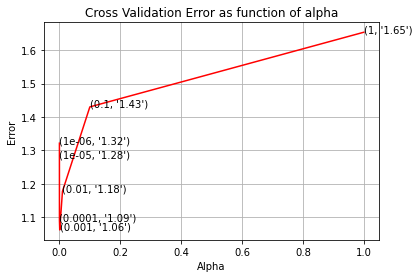

In [355]:
dfg, dax = plt.subplots()
dax.plot(alpha, log_error_cv,c='r')
for im, clt in enumerate(np.round(log_error_cv,2)):
    dax.annotate((alpha[im],str(clt)), (alpha[im],log_error_cv[im]))
plt.grid()
plt.title("Cross Validation Error as function of alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

In [356]:
opt_alpha = np.argmin(log_error_cv)
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)

y_pred = sig_clsf.predict_proba(train_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Training:",log_loss(y_train, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(cv_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Cross-Validation:",log_loss(y_cv, y_pred, labels=clsf.classes_, eps=1e-15))
y_pred = sig_clsf.predict_proba(test_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], "Log Loss on Test:",log_loss(y_test, y_pred, labels=clsf.classes_, eps=1e-15))

For the best alpha =  0.001 Log Loss on Training: 0.5965957693202367
For the best alpha =  0.001 Log Loss on Cross-Validation: 1.0626818620853384
For the best alpha =  0.001 Log Loss on Test: 1.208609274024185


Log Loss : 1.0626818620853384
Number of Mis-Classified Points : 0.34022556390977443
-------------------- Confusion Matrix --------------------


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


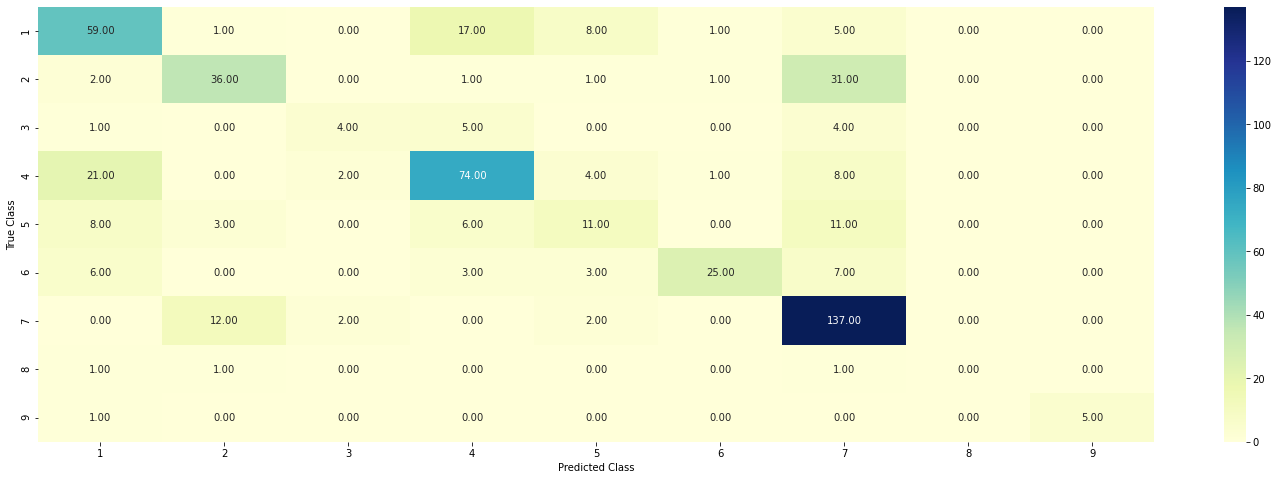

-------------------- Precision Matrix --------------------


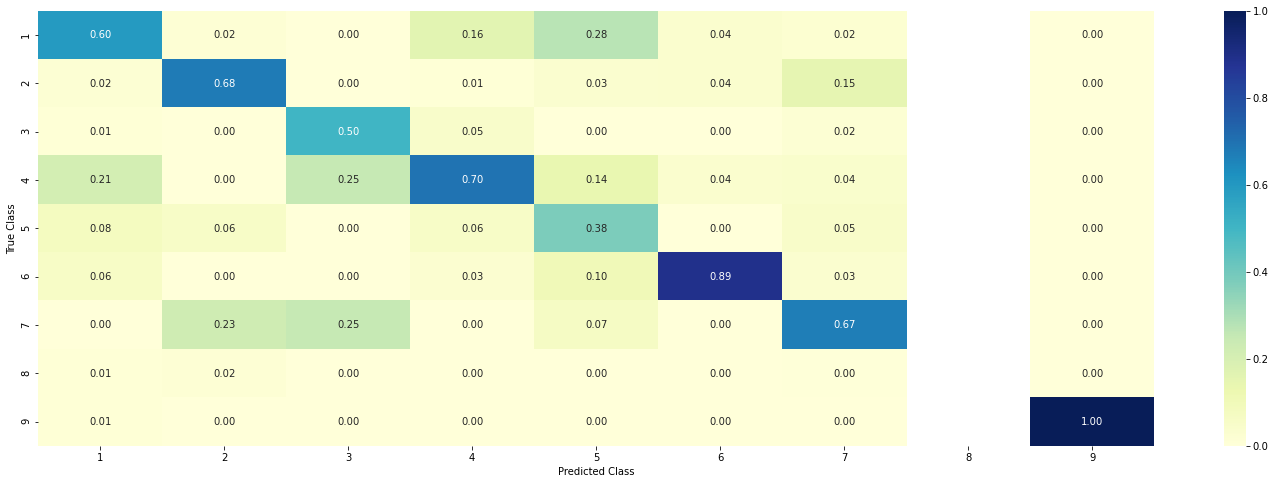

-------------------- Recall Matrix --------------------


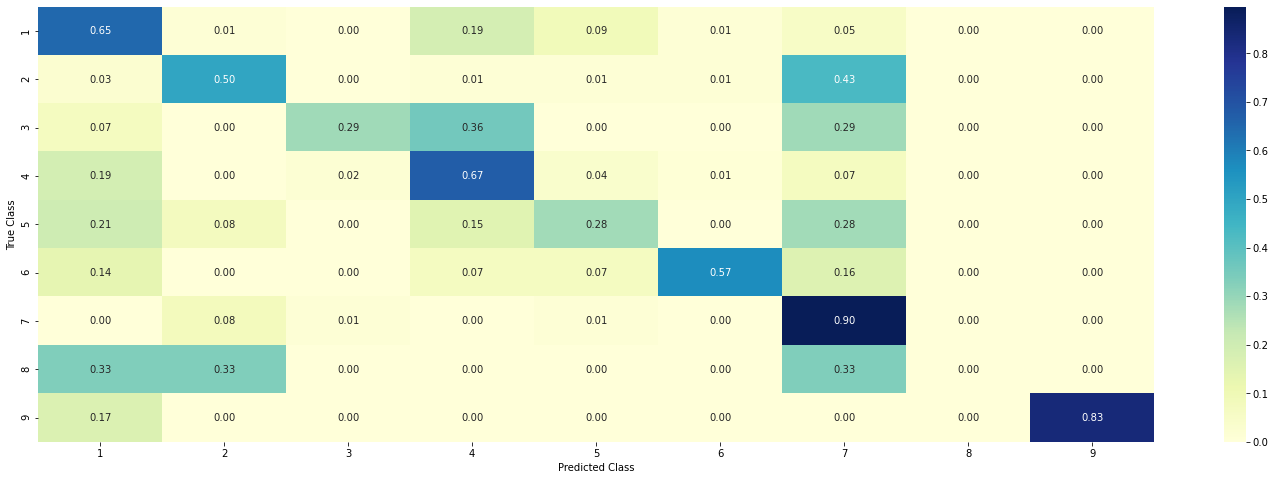

In [357]:
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
conf_mat_pred_plot(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clsf)

## Testing query point and interpretability

In [358]:
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='log', random_state=42)
clsf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[1.200e-03 8.803e-01 5.000e-04 5.000e-04 7.000e-04 2.100e-03 1.083e-01
  6.400e-03 0.000e+00]]
Actual Class : 2
--------------------------------------------------
26 Text feature [nonmutant] present in test data point [True]
45 Text feature [mechanisms] present in test data point [True]
121 Text feature [researchers] present in test data point [True]
131 Text feature [messenger] present in test data point [True]
160 Text feature [contain] present in test data point [True]
169 Text feature [importantly] present in test data point [True]
192 Text feature [penetration] present in test data point [True]
195 Text feature [pattern] present in test data point [True]
206 Text feature [could] present in test data point [True]
237 Text feature [manuscript] present in test data point [True]
252 Text feature [subcloned] present in test data point [True]
255 Text feature [structures] present in test data point [True]
293 Text feature [internal] pr

## 4.Linear Support Vector Machines

In [359]:
alpha = [10 ** x for x in range(-5, 3)]
log_error_cv = []
for i in alpha:
    print("for C =", i)
#     clsf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clsf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
    sig_clsf.fit(train_x_onehotCoding, train_y)
    sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding)
    log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clsf_probs)) 

for C = 1e-05
Log Loss : 1.3232500840018993
for C = 0.0001
Log Loss : 1.2472774266469295
for C = 0.001
Log Loss : 1.1755342316188226
for C = 0.01
Log Loss : 1.1799120354822192
for C = 0.1
Log Loss : 1.4101097722554672
for C = 1
Log Loss : 1.7028301670385935
for C = 10
Log Loss : 1.7217945385803328
for C = 100
Log Loss : 1.7217945932622798


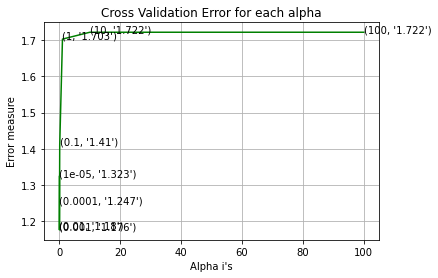

In [360]:
fig, ax = plt.subplots()
ax.plot(alpha, log_error_cv,c='g')
for i, txt in enumerate(np.round(log_error_cv,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],log_error_cv[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [361]:
opt_alpha = np.argmin(log_error_cv)
# clsf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clsf = SGDClassifier(class_weight='balanced', alpha=alpha[opt_alpha], penalty='l2', loss='hinge', random_state=42)
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clsf.predict_proba(train_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], 
      "The train log loss is:",log_loss(y_train, predict_y, labels=clsf.classes_, eps=1e-15))

predict_y = sig_clsf.predict_proba(cv_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha],
      "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))

predict_y = sig_clsf.predict_proba(test_x_onehotCoding)
print('For the best alpha = ', alpha[opt_alpha], 
      "The test log loss is:",log_loss(y_test, predict_y, labels=clsf.classes_, eps=1e-15))

For the best alpha =  0.001 The train log loss is: 0.7244755023749179
For the best alpha =  0.001 The cross validation log loss is: 1.1755342316188226
For the best alpha =  0.001 The test log loss is: 1.2808125641381138


### Testing model with best alpha values

Log Loss : 1.1755342316188226
Number of Mis-Classified Points : 0.35150375939849626
-------------------- Confusion Matrix --------------------


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


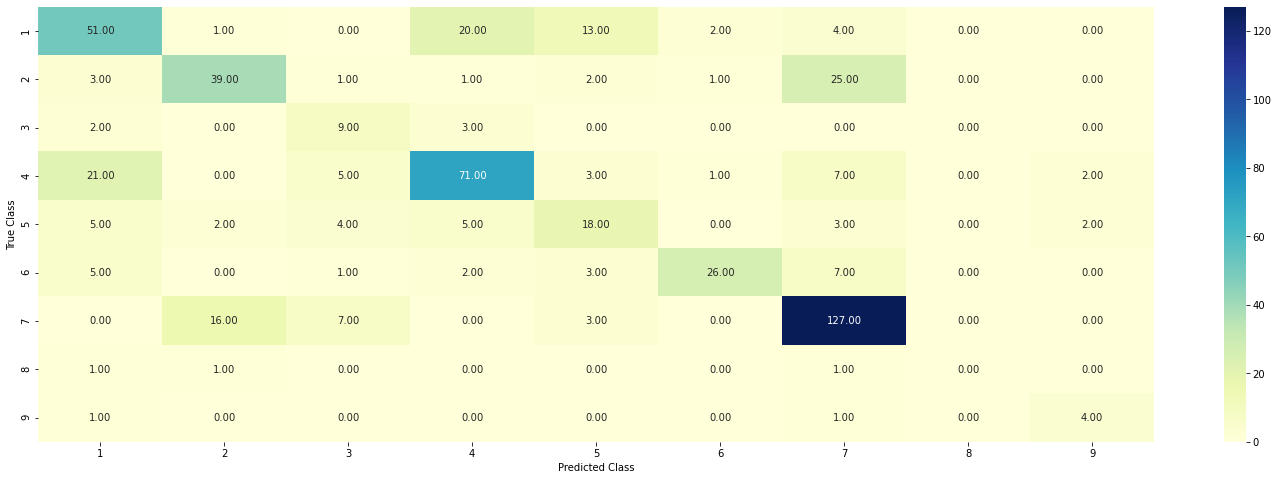

-------------------- Precision Matrix --------------------


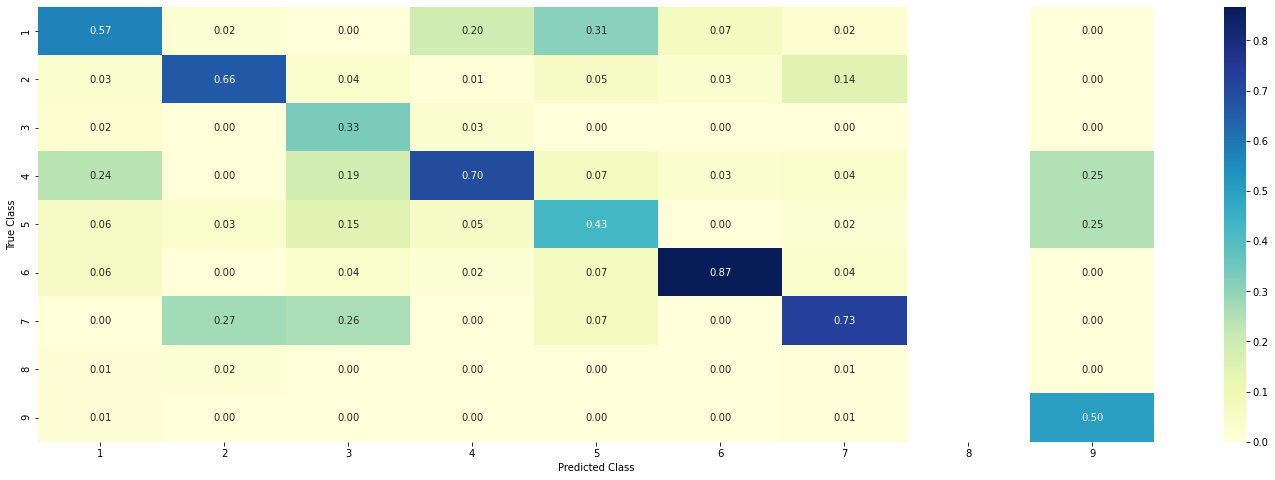

-------------------- Recall Matrix --------------------


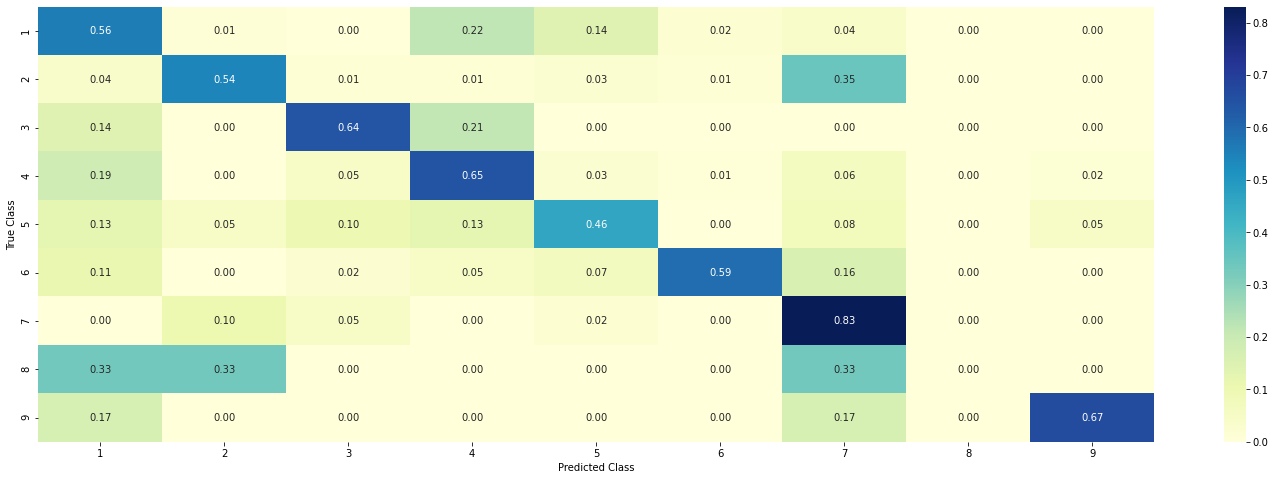

In [362]:
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
conf_mat_pred_plot(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clsf)

Querying some correctly classified point

In [363]:
clsf = SGDClassifier(alpha=alpha[opt_alpha], penalty='l2', loss='hinge', random_state=42)
clsf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0371 0.6415 0.0021 0.0184 0.0079 0.0609 0.2238 0.0045 0.0038]]
Actual Class : 2
--------------------------------------------------
27 Text feature [nonmutant] present in test data point [True]
102 Text feature [importantly] present in test data point [True]
104 Text feature [suitable] present in test data point [True]
161 Text feature [researchers] present in test data point [True]
170 Text feature [32] present in test data point [True]
191 Text feature [degree] present in test data point [True]
205 Text feature [mechanisms] present in test data point [True]
208 Text feature [series] present in test data point [True]
214 Text feature [biochemical] present in test data point [True]
240 Text feature [penetration] present in test data point [True]
244 Text feature [ros1g2032r] present in test data point [True]
280 Text feature [messenger] present in test data point [True]
308 Text feature [contain] present in test data point [True]
39

## 5.Random Forest Classifier

### Model with One hot encoder

In [364]:
# For RF classifier we have two hyperparameters n_estimators and max_depth
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]

log_error_cv = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clsf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clsf.fit(train_x_onehotCoding, train_y)
        sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
        sig_clsf.fit(train_x_onehotCoding, train_y)
        sig_clsf_probs = sig_clsf.predict_proba(cv_x_onehotCoding)
        log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clsf_probs)) 


for n_estimators = 100 and max depth =  5
Log Loss : 1.2562043877889246
for n_estimators = 100 and max depth =  10
Log Loss : 1.1712962846713537
for n_estimators = 200 and max depth =  5
Log Loss : 1.2493249146620569
for n_estimators = 200 and max depth =  10
Log Loss : 1.1619451027185004
for n_estimators = 500 and max depth =  5
Log Loss : 1.2460669085196279
for n_estimators = 500 and max depth =  10
Log Loss : 1.153377779551311
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2440488379082988
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1499651264725699
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2422363047307232
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1504756726775063


In [365]:
opt_alpha = np.argmin(log_error_cv)
clsf = RandomForestClassifier(n_estimators=alpha[int(opt_alpha/2)], criterion='gini', max_depth=max_depth[int(opt_alpha%2)], random_state=42, n_jobs=-1)
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clsf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(opt_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(opt_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(opt_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clsf.classes_, eps=1e-15))

For values of best estimator =  1000 The train log loss is: 0.7057035823880989
For values of best estimator =  1000 The cross validation log loss is: 1.1499651264725699
For values of best estimator =  1000 The test log loss is: 1.2291102941654544


Lets test it on testing data using best hyper param

Log Loss : 1.1499651264725699
Number of Mis-Classified Points : 0.38345864661654133
-------------------- Confusion Matrix --------------------


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


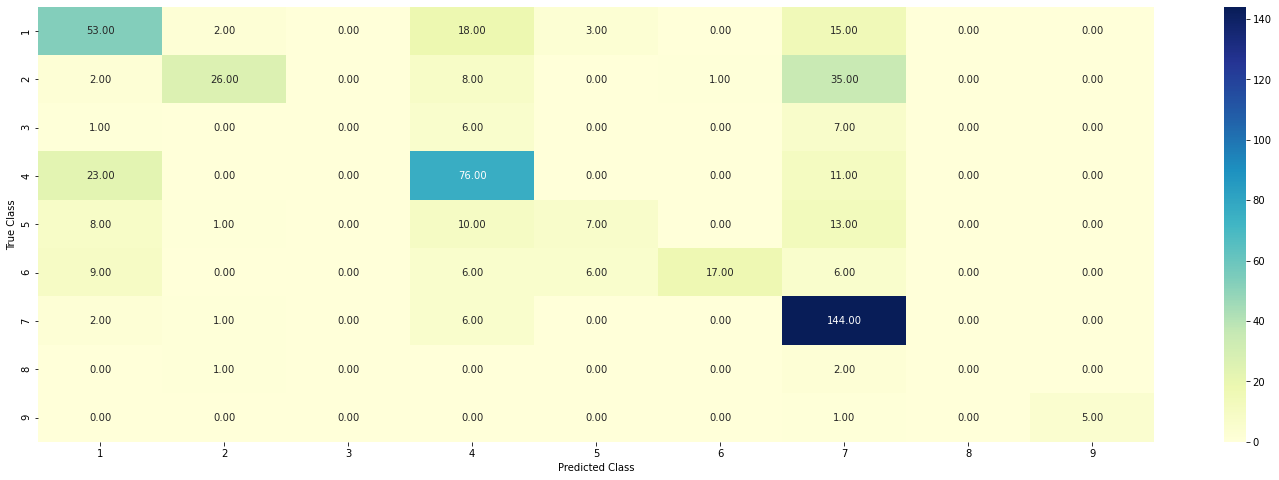

-------------------- Precision Matrix --------------------


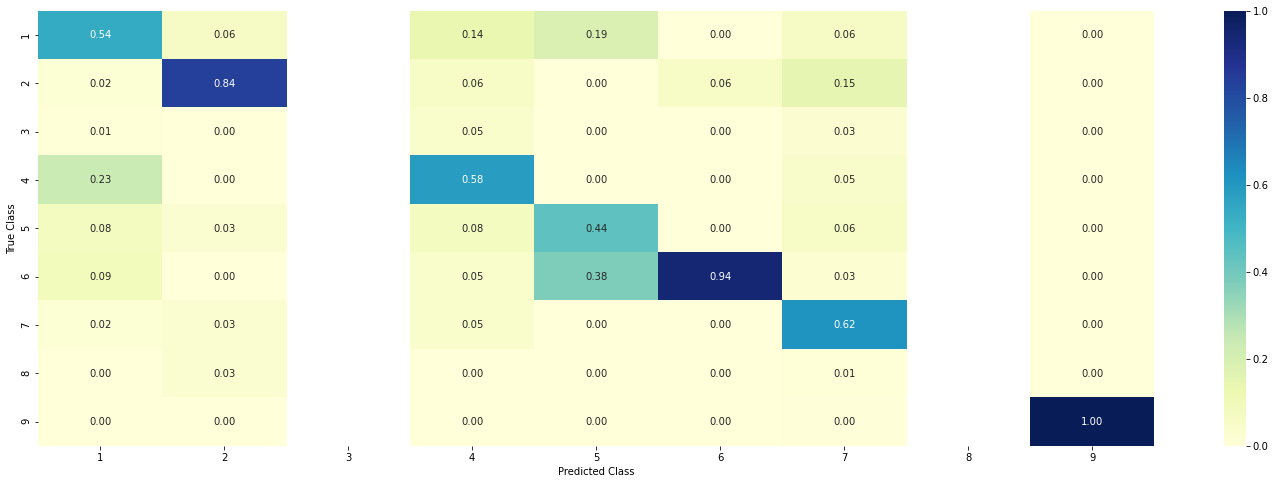

-------------------- Recall Matrix --------------------


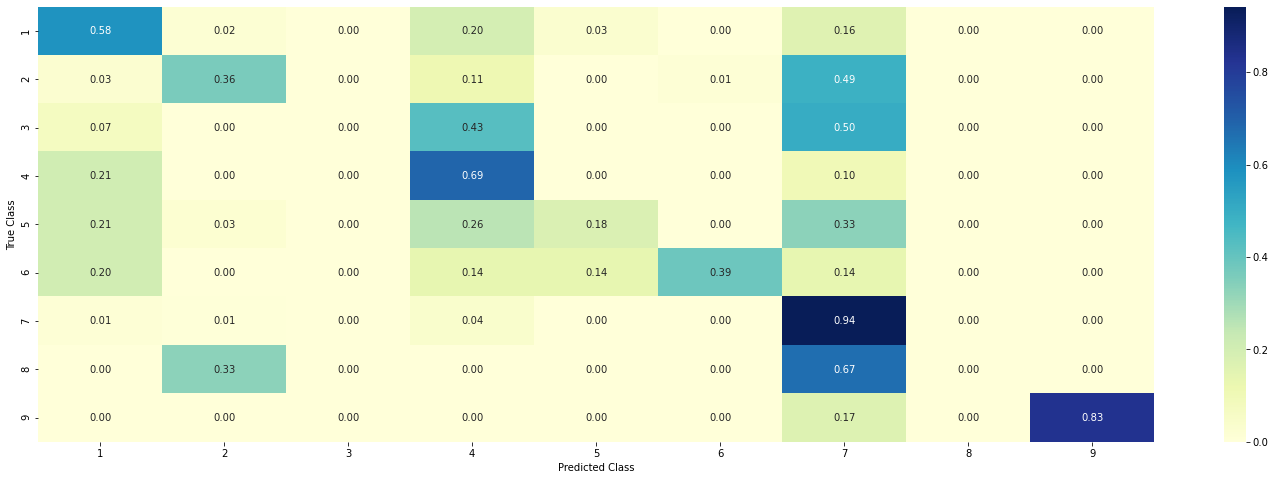

In [366]:
clsf = RandomForestClassifier(n_estimators=alpha[int(opt_alpha/2)], criterion='gini', max_depth=max_depth[int(opt_alpha%2)], random_state=42, n_jobs=-1)
conf_mat_pred_plot(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clsf)

In [367]:
# test_point_index = 10
clsf = RandomForestClassifier(n_estimators=alpha[int(opt_alpha/2)], criterion='gini', max_depth=max_depth[int(opt_alpha%2)], random_state=42, n_jobs=-1)
clsf.fit(train_x_onehotCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clsf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0246 0.245  0.0124 0.0231 0.0296 0.0261 0.6299 0.0047 0.0046]]
Actual Class : 2
--------------------------------------------------
19 Text feature [np] present in test data point [True]
56 Text feature [consent] present in test data point [True]
63 Text feature [cabozantinib] present in test data point [True]
67 Text feature [potency] present in test data point [True]
71 Text feature [existence] present in test data point [True]
79 Text feature [processing] present in test data point [True]
83 Text feature [cetuximab] present in test data point [True]
Out of the top  100  features  7 are present in query point


## RF with Response Coding

In [368]:
alpha = [10,50,100,200,500,1000] #n-estimators
max_depth = [2,3,5,10]
log_error_cv = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clsf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clsf.fit(train_x_responseCoding, train_y)
        sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
        sig_clsf.fit(train_x_responseCoding, train_y)
        sig_clsf_probs = sig_clsf.predict_proba(cv_x_responseCoding)
        log_error_cv.append(log_loss(cv_y, sig_clsf_probs, labels=clsf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clsf_probs)) 


for n_estimators = 10 and max depth =  2
Log Loss : 1.9707736765013153
for n_estimators = 10 and max depth =  3
Log Loss : 1.6858566962457648
for n_estimators = 10 and max depth =  5
Log Loss : 1.5788309275176478
for n_estimators = 10 and max depth =  10
Log Loss : 1.68585878655952
for n_estimators = 50 and max depth =  2
Log Loss : 1.6867436782011405
for n_estimators = 50 and max depth =  3
Log Loss : 1.4504106508723802
for n_estimators = 50 and max depth =  5
Log Loss : 1.3971260035135435
for n_estimators = 50 and max depth =  10
Log Loss : 1.7000216266640926
for n_estimators = 100 and max depth =  2
Log Loss : 1.5574596033689367
for n_estimators = 100 and max depth =  3
Log Loss : 1.4867751548927683
for n_estimators = 100 and max depth =  5
Log Loss : 1.377311549693167
for n_estimators = 100 and max depth =  10
Log Loss : 1.7205530886730318
for n_estimators = 200 and max depth =  2
Log Loss : 1.5816635391879836
for n_estimators = 200 and max depth =  3
Log Loss : 1.4690646858393686


In [369]:
opt_alpha = np.argmin(log_error_cv)
clsf = RandomForestClassifier(n_estimators=alpha[int(opt_alpha/4)], criterion='gini', max_depth=max_depth[int(opt_alpha%4)], random_state=42, n_jobs=-1)
clsf.fit(train_x_responseCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_responseCoding, train_y)

predict_y = sig_clsf.predict_proba(train_x_responseCoding)
print('For the best alpha = ', alpha[int(opt_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(cv_x_responseCoding)
print('For the best alpha = ', alpha[int(opt_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clsf.classes_, eps=1e-15))
predict_y = sig_clsf.predict_proba(test_x_responseCoding)
print('For the best alpha = ', alpha[int(opt_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clsf.classes_, eps=1e-15))

For the best alpha =  100 The train log loss is: 0.06623352540607311
For the best alpha =  100 The cross validation log loss is: 1.377311549693167
For the best alpha =  100 The test log loss is: 1.4040292853371006


Testing model with best hyper param

Log Loss : 1.377311549693167
Number of Mis-Classified Points : 0.5263157894736842
-------------------- Confusion Matrix --------------------


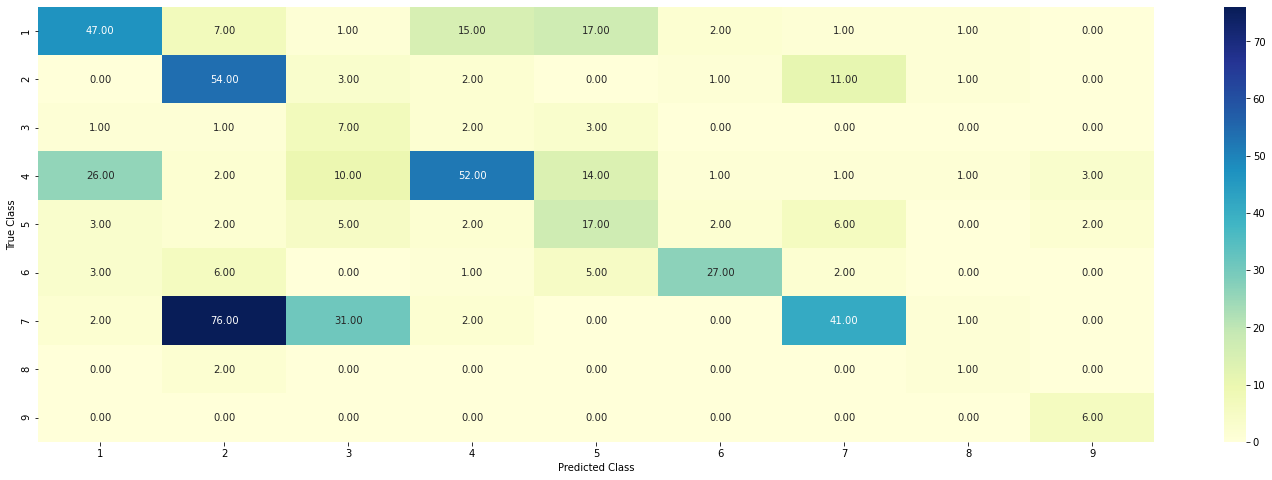

-------------------- Precision Matrix --------------------


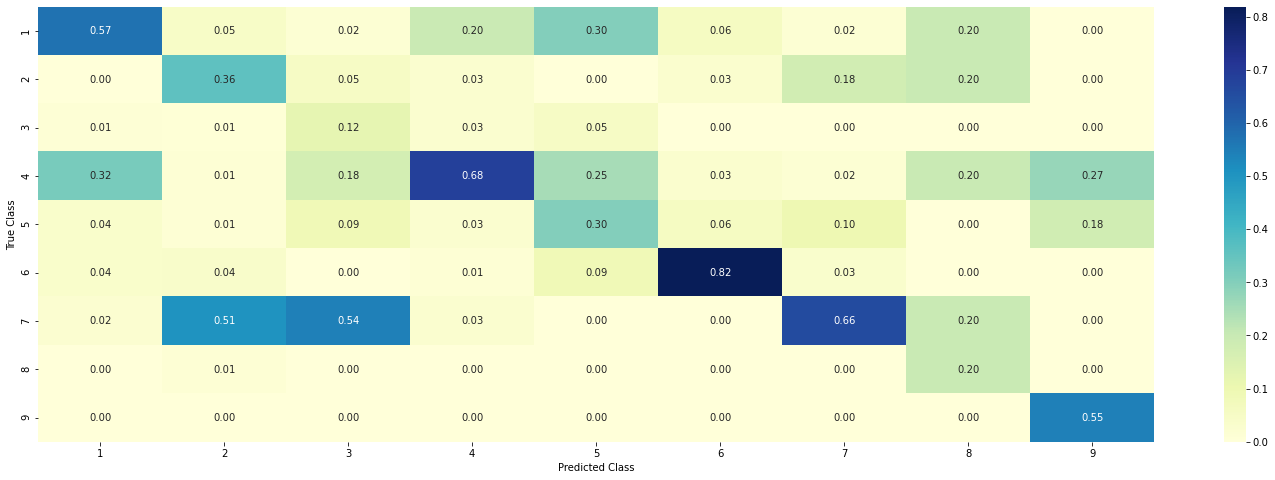

-------------------- Recall Matrix --------------------


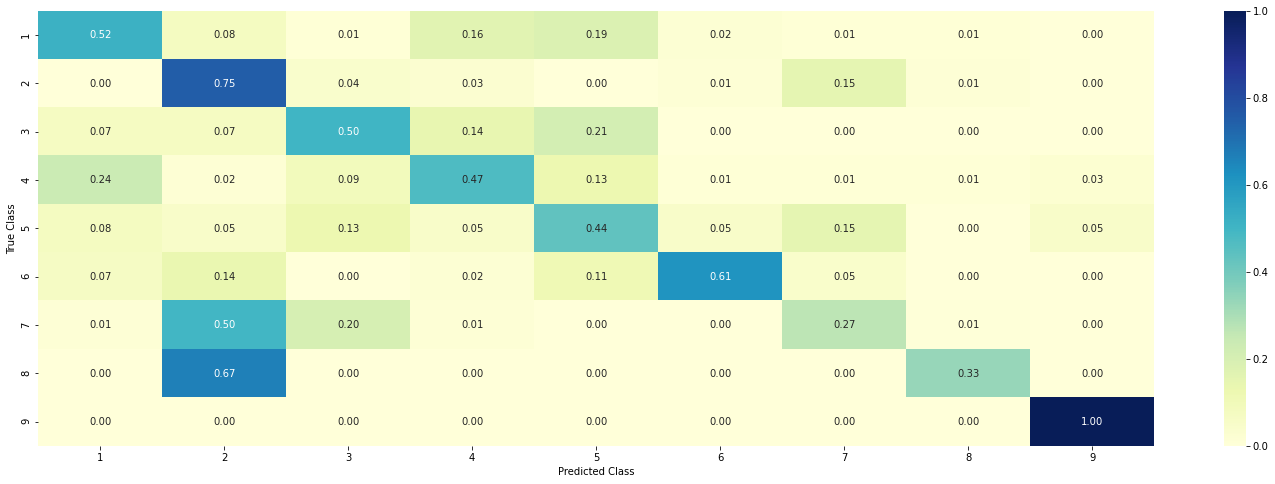

In [370]:
clsf = RandomForestClassifier(max_depth=max_depth[int(opt_alpha%4)], n_estimators=alpha[int(opt_alpha/4)], criterion='gini', max_features='auto',random_state=42)
conf_mat_pred_plot(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clsf)

Query the classified point

In [371]:
clsf = RandomForestClassifier(n_estimators=alpha[int(opt_alpha/4)], criterion='gini', max_depth=max_depth[int(opt_alpha%4)], random_state=42, n_jobs=-1)
clsf.fit(train_x_responseCoding, train_y)
sig_clsf = CalibratedClassifierCV(clsf, method="sigmoid")
sig_clsf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clsf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clsf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clsf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0119 0.681  0.0962 0.0164 0.0214 0.0402 0.1069 0.0179 0.008 ]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Gene is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


# Stacking model

In [372]:
clsf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clsf1.fit(train_x_onehotCoding, train_y)
sig_clsf1 = CalibratedClassifierCV(clsf1, method="sigmoid")

clsf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clsf2.fit(train_x_onehotCoding, train_y)
sig_clsf2 = CalibratedClassifierCV(clsf2, method="sigmoid")


clsf3 = MultinomialNB(alpha=0.001)
clsf3.fit(train_x_onehotCoding, train_y)
sig_clsf3 = CalibratedClassifierCV(clsf3, method="sigmoid")

sig_clsf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clsf1.predict_proba(cv_x_onehotCoding))))
sig_clsf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clsf2.predict_proba(cv_x_onehotCoding))))
sig_clsf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clsf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
opt_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclsf = StackingClassifier(classifiers=[sig_clsf1, sig_clsf2, sig_clsf3], meta_classifier=lr, use_probas=True)
    sclsf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclsf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclsf.predict_proba(cv_x_onehotCoding))
    if opt_alpha > log_error:
        opt_alpha = log_error

Logistic Regression :  Log Loss: 1.06
Support vector machines : Log Loss: 1.70
Naive Bayes : Log Loss: 1.28
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.820
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.737
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.363
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.141
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.296


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.503


### Testing with best hyper param

Log loss (train) on the stacking classifier : 0.5919460986866998
Log loss (CV) on the stacking classifier : 1.1410920696530735
Log loss (test) on the stacking classifier : 1.2686185277388693
Number of missclassified point : 0.3774436090225564


<ipython-input-329-e05e39e3fdfb>:7: RuntimeWarning: invalid value encountered in true_divide
  BP =(CM/CM.sum(axis=0))


-------------------- Confusion Matrix --------------------


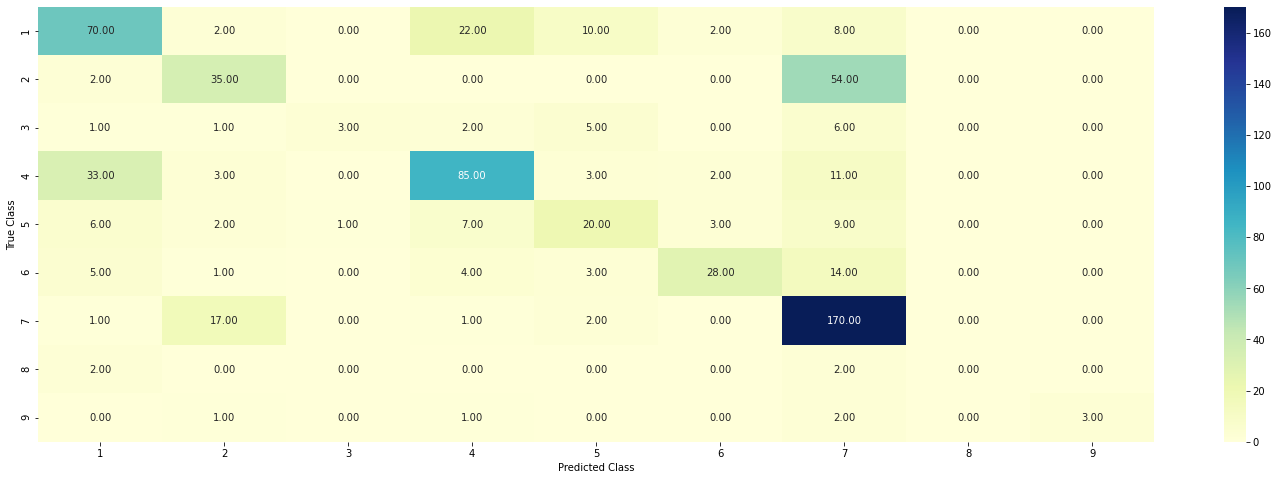

-------------------- Precision Matrix --------------------


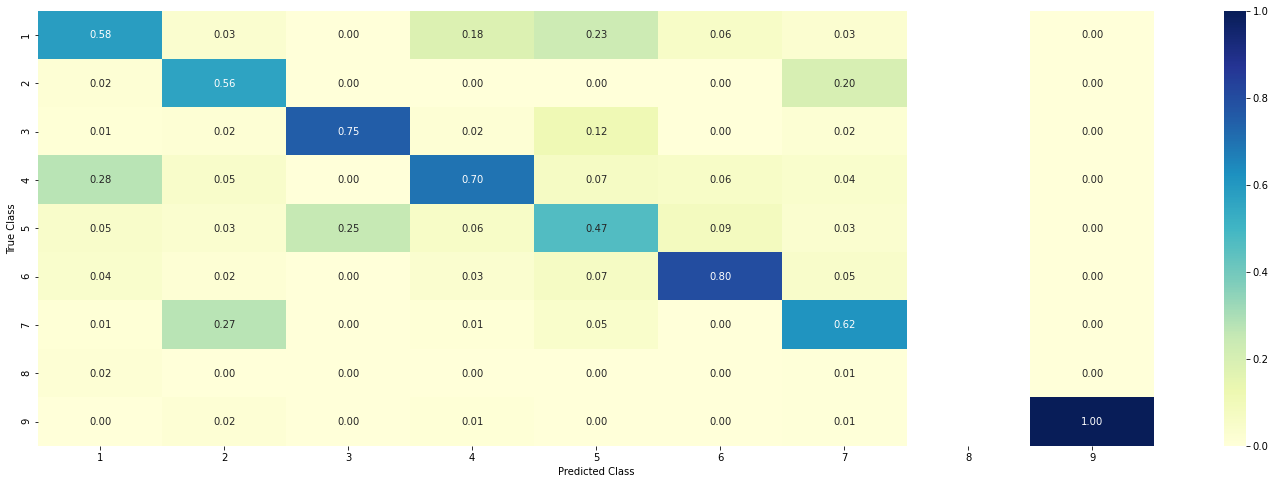

-------------------- Recall Matrix --------------------


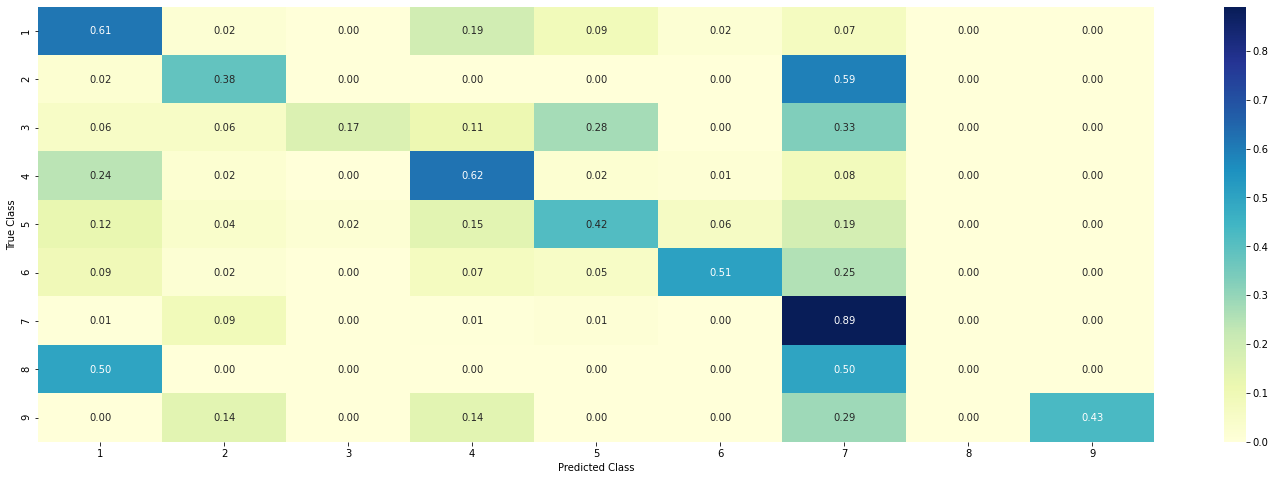

In [373]:
lr = LogisticRegression(C=0.1)
sclsf = StackingClassifier(classifiers=[sig_clsf1, sig_clsf2, sig_clsf3], meta_classifier=lr, use_probas=True)
sclsf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclsf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclsf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclsf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclsf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
confusion_mat_plot(test_y=test_y, predict_y=sclsf.predict(test_x_onehotCoding))

# Maximum voting Classifier

Log loss (Train) on the VotingClassifier : 0.9203351647244101
Log loss (CV) on the VotingClassifier : 1.1971881700650717
Log loss (Test) on the VotingClassifier : 1.2700009177920502
Number of missclassified point : 0.3819548872180451
-------------------- Confusion Matrix --------------------


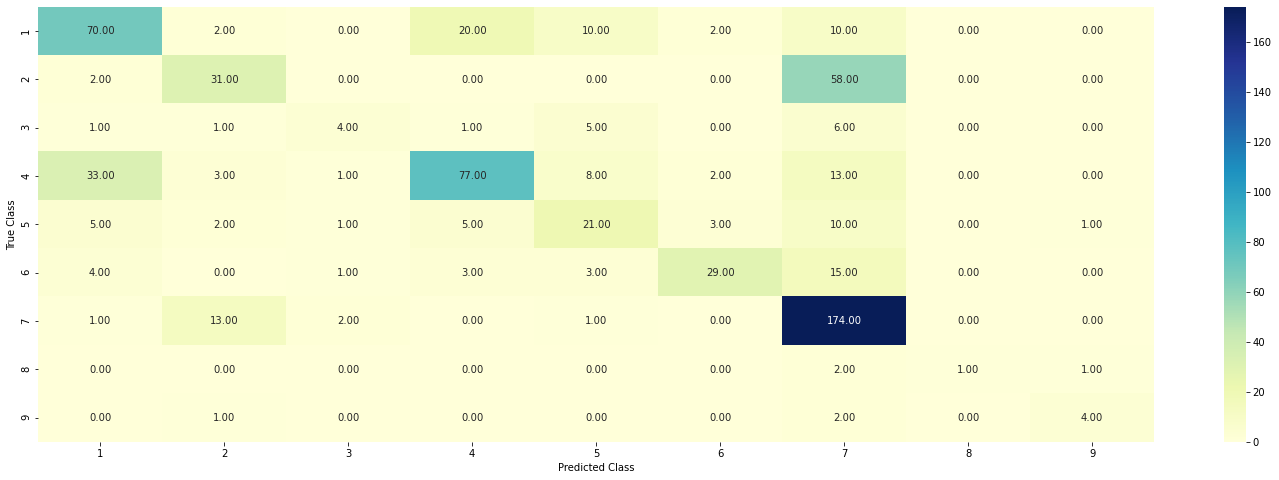

-------------------- Precision Matrix --------------------


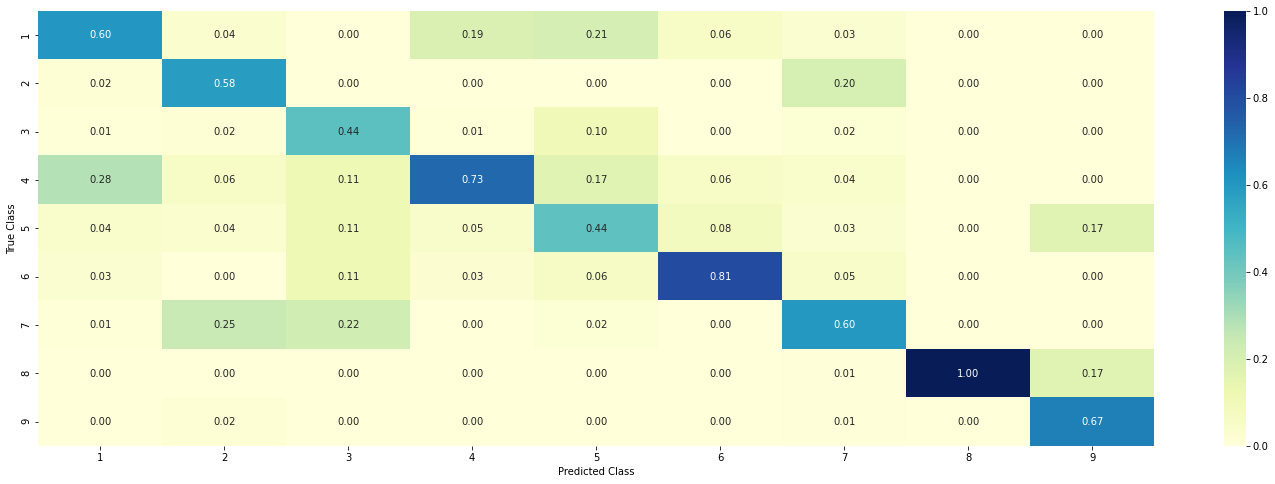

-------------------- Recall Matrix --------------------


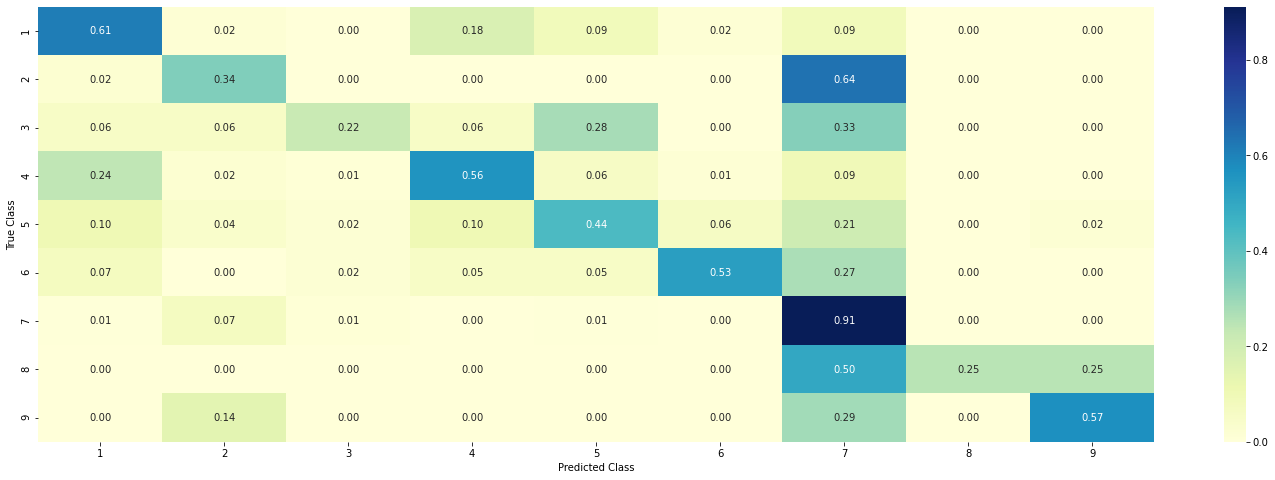

In [374]:
from sklearn.ensemble import VotingClassifier
vclsf = VotingClassifier(estimators=[('lr', sig_clsf1), ('svc', sig_clsf2), ('rf', sig_clsf3)], voting='soft')
vclsf.fit(train_x_onehotCoding, train_y)
print("Log loss (Train) on the VotingClassifier :", log_loss(train_y, vclsf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclsf.predict_proba(cv_x_onehotCoding)))
print("Log loss (Test) on the VotingClassifier :", log_loss(test_y, vclsf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclsf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
confusion_mat_plot(test_y=test_y, predict_y=vclsf.predict(test_x_onehotCoding))

### Linear regression with balanced classes produces the lowest log loss score thus is the best model here.